In [3]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from scipy.signal import savgol_filter

In [4]:
# ========== 🔹 STEP 1: FILE RENAMING (Ceara Rise Data) ==========
def rename_files(directory):
    folder = Path(directory)
    
    # Remove "Count and Measure of " prefix
    for file in folder.iterdir():
        if file.name.startswith("Count and Measure of "):
            new_filename = file.name.replace("Count and Measure of ", "").strip()
            file.rename(folder / new_filename)
            print(f"Renamed: {file.name} -> {new_filename}")

    # Remove spaces in filenames
    for file in folder.iterdir():
        new_filename = file.name.replace(" ", "")
        if file.name != new_filename:
            file.rename(folder / new_filename)
            print(f"Renamed: {file.name} -> {new_filename}")

directory_path = './Ceara Rise data'
rename_files(directory_path)

# Get list of cleaned files
folder_path = Path('Ceara Rise data')
files = [f for f in folder_path.iterdir() if f.is_file()]
print(f"✅ Found {len(files)} files after renaming.")

✅ Found 863 files after renaming.


In [5]:
def load_and_clean_mastersheet(filepath):
    df_raw = pd.read_excel(filepath, header=None)

    header_keywords = ['SITE', 'HOLE', 'CORE', 'CORE_TYPE', 'SECTION', 'TOP_DEPTH', 'BOTTOM_DEPTH']
    header_row_index = None

    for i in range(len(df_raw)):
        row_values = df_raw.iloc[i].astype(str).str.upper().tolist()
        if all(key in row_values for key in header_keywords):
            header_row_index = i
            break

    if header_row_index is None:
        print("❌ Header row with expected keywords not found.")
        return None

    print(f"✅ Found header at row index: {header_row_index}")
    
    df = pd.read_excel(filepath, header=header_row_index)
    df.columns = df.columns.str.strip().str.upper()  # Normalize column names

    print("📋 Cleaned column names:")
    print(df.columns.tolist())

    # Drop unnamed or completely empty columns
    df = df.loc[:, ~df.columns.str.contains('^UNNAMED', case=False)]
    df = df.dropna(axis=1, how='all')

    if 'SITE' not in df.columns:
        print("❌ 'SITE' column still missing after normalization.")
        return None

    df = df[pd.to_numeric(df['SITE'], errors='coerce').notnull()]

    df['SITE'] = df['SITE'].astype(float)
    df['HOLE'] = df['HOLE'].astype(str).str.upper()
    df['CORE'] = pd.to_numeric(df['CORE'], errors='coerce')
    df['CORE_TYPE'] = df['CORE_TYPE'].astype(str).str.upper()
    df['SECTION'] = pd.to_numeric(df['SECTION'], errors='coerce')
    df['TOP_DEPTH'] = pd.to_numeric(df['TOP_DEPTH'], errors='coerce')
    df['BOTTOM_DEPTH'] = pd.to_numeric(df['BOTTOM_DEPTH'], errors='coerce')

    df.dropna(subset=['SITE', 'CORE', 'SECTION', 'TOP_DEPTH', 'BOTTOM_DEPTH'], inplace=True)

    return df


In [6]:
agedb = load_and_clean_mastersheet('925_Mastersheet.xlsx')
if agedb is not None:
    print("✅ Successfully loaded and cleaned 925_Mastersheet.xlsx")
    print(agedb.head())

✅ Found header at row index: 1
📋 Cleaned column names:
['UNNAMED: 0', 'EXPEDITION', 'SITE', 'HOLE', 'CORE', 'CORE_TYPE', 'SECTION', 'CC', 'TOP_DEPTH', 'BOTTOM_DEPTH', 'MBSF_TOP', 'MCD_TOP', 'AGE (MA)', 'SPLITS', 'SIZE.MEAN.AREA', 'SIZE.MEAN.DIAMETERMEAN', 'SIZE.MEAN.DIAMETERMIN', 'SIZE.MEAN.DIAMETERMAX', 'SIZE.MEAN.SPHERICITY', 'SIZE.MEAN.SHAPEFACTOR', 'SIZE.MEDIAN.AREA', 'SIZE.MEDIAN.DIAMETERMEAN', 'SIZE.MEDIAN.DIAMETERMIN', 'SIZE.MEDIAN.DIAMETERMAX', 'SIZE.MEDIAN.SPHERICITY', 'SIZE.MEDIAN.SHAPEFACTOR', 'SIZE.SD.AREA', 'SIZE.SD.DIAMETERMEAN', 'SIZE.SD.DIAMETERMIN', 'SIZE.SD.DIAMETERMAX', 'SIZE.SD.SPHERICITY', 'SIZE.SD.SHAPEFACTOR', 'SIZE.95.AREA', 'SIZE.95.DIAMETERMEAN', 'SIZE.95.DIAMETERMIN', 'SIZE.95.DIAMETERMAX', 'SIZE.95.SPHERICITY', 'SIZE.95.SHAPEFACTOR', 'SIZE.9.AREA', 'SIZE.9.DIAMETERMEAN', 'SIZE.9.DIAMETERMIN', 'SIZE.9.DIAMETERMAX', 'SIZE.9.SPHERICITY', 'SIZE.9.SHAPEFACTOR', 'SIZE.SKEWNESS.AREA', 'SIZE.SKEWNESS.DIAMETERMEAN', 'SIZE.SKEWNESS.DIAMETERMIN', 'SIZE.SKEWNESS.DIAMETE

In [7]:
df_raw = pd.read_excel('925_Mastersheet.xlsx', header=None)
print("🔍 Raw first few rows:")
print(df_raw.head(10))

print("\n📌 Columns guessed by pandas after reading raw:")
print(df_raw.iloc[0:5].values)


🔍 Raw first few rows:
     0            1     2     3     4          5        6    7          8   \
0   NaN  SAMPLE INFO   NaN   NaN   NaN        NaN      NaN  NaN        NaN   
1   NaN   EXPEDITION  SITE  HOLE  CORE  CORE_TYPE  SECTION   CC  TOP_DEPTH   
2  29.0          154   925     C     1          H        1   no         43   
3  30.0          154   925     C     1          H        1   no         62   
4  31.0          154   925     C     1          H        1   no         68   
5  32.0          154   925     C     1          H        1   no         88   
6  33.0          154   925     C     1          H        1   no        103   
7  34.0          154   925     C     1          H        1   no        108   
8  35.0          154   925     C     1          H        1   no        133   
9  36.0          154   925     C     1          H        1   no        138   

             9   ...          60      61                       62  \
0           NaN  ...         NaN     NaN          

In [8]:
df_test = pd.read_excel('925_Mastersheet.xlsx')
print("👀 Columns as interpreted by pandas:")
print(df_test.columns.tolist())


👀 Columns as interpreted by pandas:
['Unnamed: 0', 'SAMPLE INFO', 'Unnamed: 2', 'Unnamed: 3', 'Unnamed: 4', 'Unnamed: 5', 'Unnamed: 6', 'Unnamed: 7', 'Unnamed: 8', 'Unnamed: 9', 'Unnamed: 10', 'Unnamed: 11', 'Unnamed: 12', 'SIZE ANALYSIS', 'Unnamed: 14', 'Unnamed: 15', 'Unnamed: 16', 'Unnamed: 17', 'Unnamed: 18', 'Unnamed: 19', 'Unnamed: 20', 'Unnamed: 21', 'Unnamed: 22', 'Unnamed: 23', 'Unnamed: 24', 'Unnamed: 25', 'Unnamed: 26', 'Unnamed: 27', 'Unnamed: 28', 'Unnamed: 29', 'Unnamed: 30', 'Unnamed: 31', 'Unnamed: 32', 'Unnamed: 33', 'Unnamed: 34', 'Unnamed: 35', 'Unnamed: 36', 'Unnamed: 37', 'Unnamed: 38', 'Unnamed: 39', 'Unnamed: 40', 'Unnamed: 41', 'Unnamed: 42', 'Unnamed: 43', 'Unnamed: 44', 'Unnamed: 45', 'Unnamed: 46', 'Unnamed: 47', 'Unnamed: 48', 'Unnamed: 49', 'Unnamed: 50', 'Unnamed: 51', 'Unnamed: 52', 'Unnamed: 53', 'Unnamed: 54', 'Unnamed: 55', 'Unnamed: 56', 'WEIGHING', 'Unnamed: 58', 'Unnamed: 59', 'Unnamed: 60', 'Unnamed: 61', 'Unnamed: 62', 'Unnamed: 63', 'Unnamed: 64'

In [9]:
agedb = load_and_clean_mastersheet('925_Mastersheet.xlsx')
print("✅ Successfully loaded and cleaned 925_Mastersheet.xlsx")


✅ Found header at row index: 1
📋 Cleaned column names:
['UNNAMED: 0', 'EXPEDITION', 'SITE', 'HOLE', 'CORE', 'CORE_TYPE', 'SECTION', 'CC', 'TOP_DEPTH', 'BOTTOM_DEPTH', 'MBSF_TOP', 'MCD_TOP', 'AGE (MA)', 'SPLITS', 'SIZE.MEAN.AREA', 'SIZE.MEAN.DIAMETERMEAN', 'SIZE.MEAN.DIAMETERMIN', 'SIZE.MEAN.DIAMETERMAX', 'SIZE.MEAN.SPHERICITY', 'SIZE.MEAN.SHAPEFACTOR', 'SIZE.MEDIAN.AREA', 'SIZE.MEDIAN.DIAMETERMEAN', 'SIZE.MEDIAN.DIAMETERMIN', 'SIZE.MEDIAN.DIAMETERMAX', 'SIZE.MEDIAN.SPHERICITY', 'SIZE.MEDIAN.SHAPEFACTOR', 'SIZE.SD.AREA', 'SIZE.SD.DIAMETERMEAN', 'SIZE.SD.DIAMETERMIN', 'SIZE.SD.DIAMETERMAX', 'SIZE.SD.SPHERICITY', 'SIZE.SD.SHAPEFACTOR', 'SIZE.95.AREA', 'SIZE.95.DIAMETERMEAN', 'SIZE.95.DIAMETERMIN', 'SIZE.95.DIAMETERMAX', 'SIZE.95.SPHERICITY', 'SIZE.95.SHAPEFACTOR', 'SIZE.9.AREA', 'SIZE.9.DIAMETERMEAN', 'SIZE.9.DIAMETERMIN', 'SIZE.9.DIAMETERMAX', 'SIZE.9.SPHERICITY', 'SIZE.9.SHAPEFACTOR', 'SIZE.SKEWNESS.AREA', 'SIZE.SKEWNESS.DIAMETERMEAN', 'SIZE.SKEWNESS.DIAMETERMIN', 'SIZE.SKEWNESS.DIAMETE

In [10]:
# ========== 🔹 STEP 3: FILE NAME PARSING ==========
def parse_filename(file_name):
    try:
        file_name = file_name.replace(".xlsx", "").replace(".csv", "")
        parts = file_name.split(',')
        site_hole, core_coreType_section, top_bottom = parts

        site, hole = site_hole[:-1], site_hole[-1]
        core_coreType, section = core_coreType_section.split('-')
        core, coreType = core_coreType[:-1], core_coreType[-1]
        top, bottom = top_bottom.split('-')

        if bottom == '21#':  # Fix potential misreading
            bottom = '21'

        return float(site), hole, float(core), coreType, float(section), float(top), float(bottom), file_name

    except ValueError as e:
        print(f"❌ Error parsing: {file_name} -> {e}")
        return None

file_info = [parse_filename(file.name) for file in files if parse_filename(file.name) is not None]
fileName = pd.DataFrame(file_info, columns=['SITE', 'HOLE', 'CORE', 'CORE_TYPE', 'SECTION', 'TOP_DEPTH', 'BOTTOM_DEPTH', 'FILE_NAME'])
print("✅ Extracted metadata from filenames.")


✅ Extracted metadata from filenames.


In [11]:
# ========== 🔹 STEP 4: MERGE FILE METADATA WITH 925_MASTERSHEET ==========
fileName['HOLE'] = fileName['HOLE'].astype(str).str.upper()
agedb['HOLE'] = agedb['HOLE'].astype(str).str.upper()

data_age = pd.merge(agedb, fileName, on=['SITE', 'HOLE', 'CORE', 'CORE_TYPE', 'SECTION', 'TOP_DEPTH', 'BOTTOM_DEPTH'], how='inner')
data_age.to_csv('data_age.csv', index=False)
print("✅ Merged and saved data_age.csv")

✅ Merged and saved data_age.csv



🔹 Summary Statistics:
        EXPEDITION   SITE HOLE        CORE CORE_TYPE     SECTION   CC  \
count        833.0  833.0  833  833.000000       833  833.000000  833   
unique         NaN    NaN    3         NaN         1         NaN    1   
top            NaN    NaN    D         NaN         H         NaN   no   
freq           NaN    NaN  439         NaN       833         NaN  833   
mean         154.0  925.0  NaN    6.066026       NaN    3.795918  NaN   
std            0.0    0.0  NaN    3.587399       NaN    1.340613  NaN   
min          154.0  925.0  NaN    1.000000       NaN    1.000000  NaN   
25%          154.0  925.0  NaN    3.000000       NaN    3.000000  NaN   
50%          154.0  925.0  NaN    6.000000       NaN    4.000000  NaN   
75%          154.0  925.0  NaN    8.000000       NaN    5.000000  NaN   
max          154.0  925.0  NaN   15.000000       NaN    7.000000  NaN   

         TOP_DEPTH  BOTTOM_DEPTH    MBSF_TOP  ...  WASHER  \
count   833.000000    833.000000  833.0

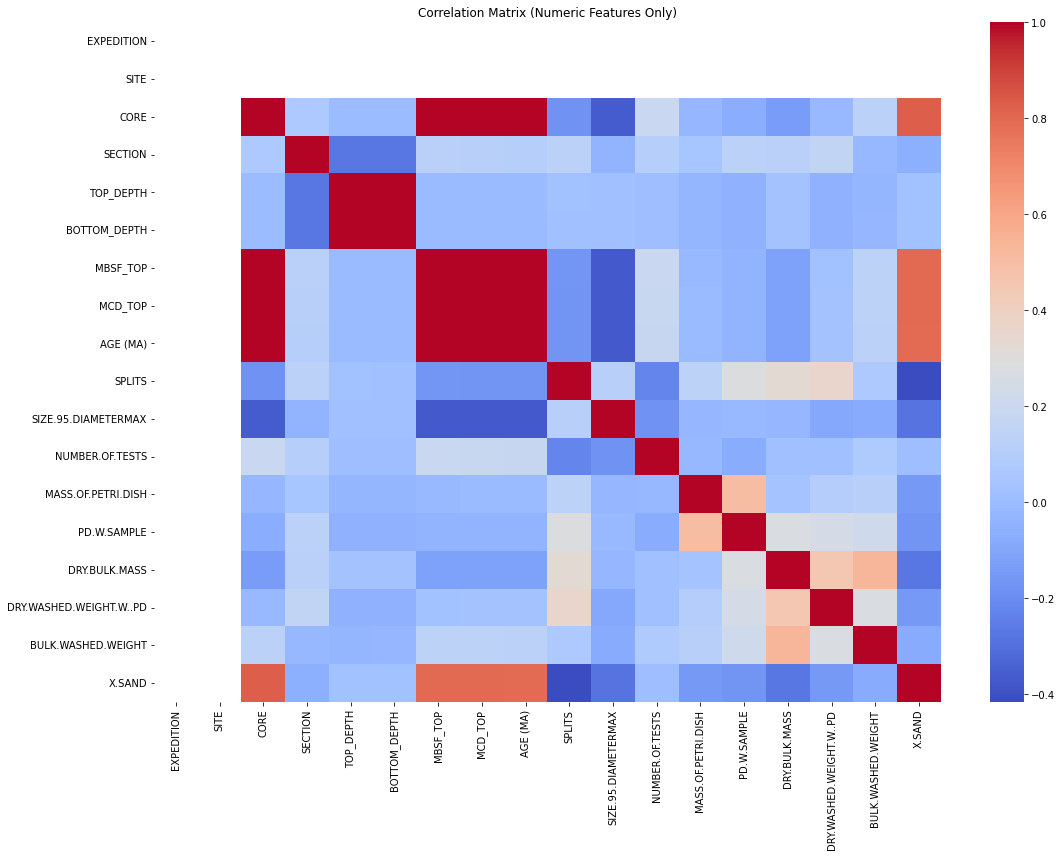

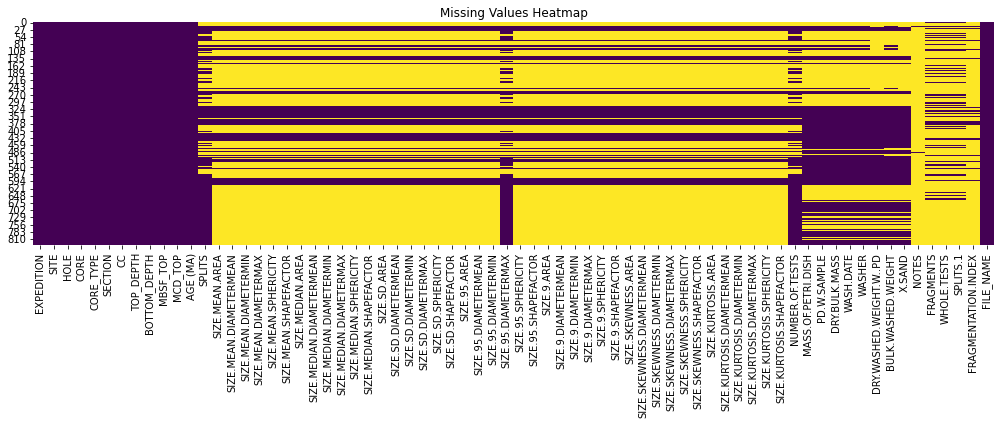

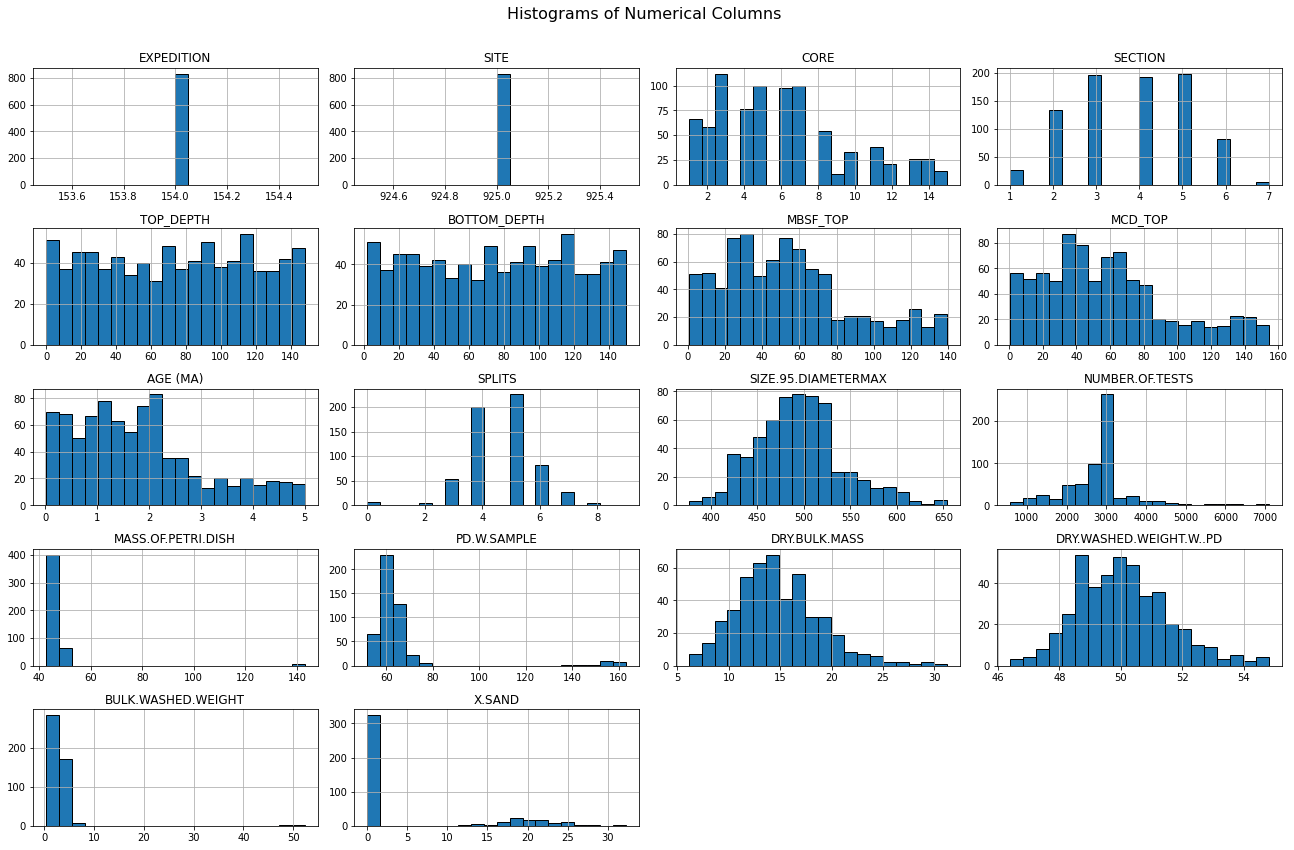

In [12]:
# ========== 🔹 STEP 5: DATA ANALYSIS ==========

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load the cleaned data
data = pd.read_csv('data_age.csv')

# Summary statistics
print("\n🔹 Summary Statistics:")
print(data.describe(include='all'))

# Missing values
print("\n🔹 Missing Values:")
print(data.isnull().sum())

# 🔹 Correlation Matrix (only for numeric columns)
numeric_data = data.select_dtypes(include=['float64', 'int64'])

# Optional: Drop numeric columns with more than 50% missing values to avoid noise
numeric_data = numeric_data.loc[:, numeric_data.isnull().mean() < 0.5]

plt.figure(figsize=(16, 12))
sns.heatmap(numeric_data.corr(), annot=False, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Matrix (Numeric Features Only)')
plt.tight_layout()
plt.show()

# 🔹 Missing Values Heatmap
plt.figure(figsize=(14, 6))
sns.heatmap(data.isnull(), cbar=False, cmap='viridis')
plt.title('Missing Values Heatmap')
plt.tight_layout()
plt.show()

# 🔹 Histograms for Numeric Columns
numeric_data.hist(bins=20, figsize=(18, 12), edgecolor='black')
plt.suptitle('Histograms of Numerical Columns', fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.97])
plt.show()


In [13]:
import pandas as pd

file_path = 'data_age.csv'
data = pd.read_csv(file_path)

print("🔍 Column names:")
print(data.columns.tolist())  # Add this line to debug

# Now continue after confirming the exact name of the age column


🔍 Column names:
['EXPEDITION', 'SITE', 'HOLE', 'CORE', 'CORE_TYPE', 'SECTION', 'CC', 'TOP_DEPTH', 'BOTTOM_DEPTH', 'MBSF_TOP', 'MCD_TOP', 'AGE (MA)', 'SPLITS', 'SIZE.MEAN.AREA', 'SIZE.MEAN.DIAMETERMEAN', 'SIZE.MEAN.DIAMETERMIN', 'SIZE.MEAN.DIAMETERMAX', 'SIZE.MEAN.SPHERICITY', 'SIZE.MEAN.SHAPEFACTOR', 'SIZE.MEDIAN.AREA', 'SIZE.MEDIAN.DIAMETERMEAN', 'SIZE.MEDIAN.DIAMETERMIN', 'SIZE.MEDIAN.DIAMETERMAX', 'SIZE.MEDIAN.SPHERICITY', 'SIZE.MEDIAN.SHAPEFACTOR', 'SIZE.SD.AREA', 'SIZE.SD.DIAMETERMEAN', 'SIZE.SD.DIAMETERMIN', 'SIZE.SD.DIAMETERMAX', 'SIZE.SD.SPHERICITY', 'SIZE.SD.SHAPEFACTOR', 'SIZE.95.AREA', 'SIZE.95.DIAMETERMEAN', 'SIZE.95.DIAMETERMIN', 'SIZE.95.DIAMETERMAX', 'SIZE.95.SPHERICITY', 'SIZE.95.SHAPEFACTOR', 'SIZE.9.AREA', 'SIZE.9.DIAMETERMEAN', 'SIZE.9.DIAMETERMIN', 'SIZE.9.DIAMETERMAX', 'SIZE.9.SPHERICITY', 'SIZE.9.SHAPEFACTOR', 'SIZE.SKEWNESS.AREA', 'SIZE.SKEWNESS.DIAMETERMEAN', 'SIZE.SKEWNESS.DIAMETERMIN', 'SIZE.SKEWNESS.DIAMETERMAX', 'SIZE.SKEWNESS.SPHERICITY', 'SIZE.SKEWNESS.SHA

In [16]:
# ========== 🔹 STEP 6: SMOOTHING DATA & PLOTTING ==========
file_path = 'data_age.csv'
data = pd.read_csv(file_path)
data = data.sort_values(by='Age (Ma)').reset_index(drop=True)

columns_to_plot = [
    'Min (Diameter) (µm)', 'Max (Diameter) (µm)', 'Mean (Diameter) (µm)', 
    'Elongation', 'Sphericity', 'Shape Factor', 
    'Mean (Gray Intensity Value)', 'Area (µm²)', 'Perimeter (µm)'
]

fig, axes = plt.subplots(len(columns_to_plot), 1, figsize=(10, 3 * len(columns_to_plot)))

for i, col in enumerate(columns_to_plot):
    ax = axes[i]
    
    smooth_data = savgol_filter(data[col].fillna(method='bfill').fillna(method='ffill'), window_length=51, polyorder=3)
    
    ax.plot(data['Age (Ma)'], smooth_data, label=f'Smoothed {col}', color='blue')
    ax.scatter(data['Age (Ma)'], data[col], color='grey', alpha=0.5, label='Data Points', s=10)
    
    ax.set_title(f'{col} vs Age')
    ax.set_xlabel('Age (Ma)')
    ax.set_ylabel(col)
    ax.legend()

plt.tight_layout()
plt.show()
print("✅ Plotted smoothed morphometric trends.")


KeyError: 'Age (Ma)'

In [17]:
import pandas as pd
import numpy as np

# Load dataset
data = pd.read_csv("analyzer_data.csv")

# Standardize column names
data.columns = data.columns.str.strip()

# Select key size distribution metrics
size_features = ["Age (Ma)", "Mean (Diameter) (µm)", "Min (Diameter) (µm)", 
                 "Max (Diameter) (µm)", "Elongation", "Sphericity", "Shape Factor", 
                 "Area (µm²)", "Perimeter (µm)"]

# Filter relevant columns
data = data[size_features].dropna()

# Sort by geological age
data = data.sort_values(by="Age (Ma)").reset_index(drop=True)

# Display dataset summary
print(data.describe())


         Age (Ma)  Mean (Diameter) (µm)  Min (Diameter) (µm)  \
count  545.000000            545.000000           545.000000   
mean     1.548223            266.706338           226.014114   
std      1.242741             17.621671            14.733214   
min      0.010531            219.361759           185.230043   
25%      0.555302            253.949516           215.246206   
50%      1.167733            265.541565           225.031001   
75%      2.269197            278.280048           236.978001   
max      5.000708            322.318126           267.833632   

       Max (Diameter) (µm)  Elongation  Sphericity  Shape Factor  \
count           545.000000  545.000000  545.000000    545.000000   
mean            300.775995    1.548287    1.014080      1.129083   
std              20.515608    0.457583    0.480190      0.475147   
min             249.198182    1.192968    0.643839      0.750084   
25%             285.808404    1.224496    0.674527      0.793829   
50%            

In [18]:
import pandas as pd
import numpy as np

# Load dataset
data2 = pd.read_csv("result.csv")

# Standardize column names
data.columns = data.columns.str.strip()

# Select key size distribution metrics
size_features = ["Age (Ma)", "Mean (Diameter) (µm)", "Min (Diameter) (µm)", 
                 "Max (Diameter) (µm)", "Elongation", "Sphericity", "Shape Factor", 
                 "Area (µm²)", "Perimeter (µm)"]

# Filter relevant columns
data = data[size_features].dropna()

# Sort by geological age
data = data.sort_values(by="Age (Ma)").reset_index(drop=True)

# Display dataset summary
print(data.describe())


FileNotFoundError: [Errno 2] No such file or directory: 'result.csv'

In [ ]:
pip install seaborn --upgrade


/var/folders/jt/0lv95mcn7f784lx7z_pw70tc0000gn/T/ipykernel_9151/1594762990.py:13: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for i, (group, subset) in enumerate(data.groupby('Age Bin')):


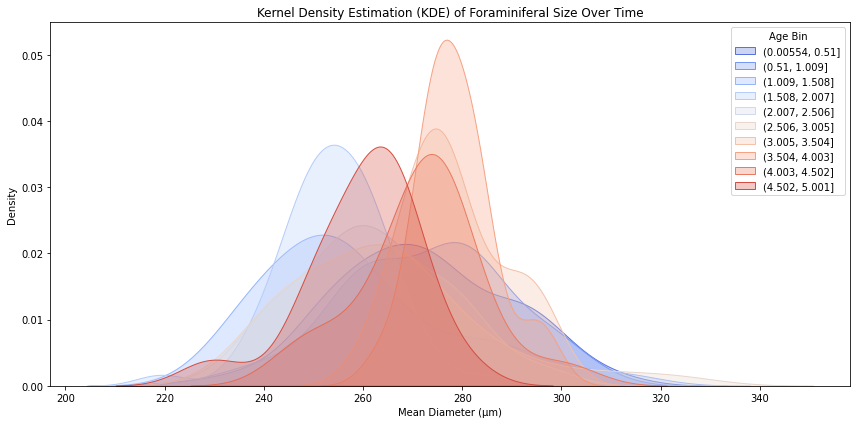

In [19]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

# Bin age data into 10 equal-sized bins
data['Age Bin'] = pd.cut(data['Age (Ma)'], bins=10)

# Set up the plot
plt.figure(figsize=(12, 6))
palette = sns.color_palette("coolwarm", n_colors=data['Age Bin'].nunique())

# Plot KDE for each age bin
for i, (group, subset) in enumerate(data.groupby('Age Bin')):
    sns.kdeplot(subset["Mean (Diameter) (µm)"], fill=True, alpha=0.3, label=str(group), color=palette[i])

plt.title("Kernel Density Estimation (KDE) of Foraminiferal Size Over Time")
plt.xlabel("Mean Diameter (µm)")
plt.ylabel("Density")
plt.legend(title="Age Bin")
plt.tight_layout()
plt.show()


In [20]:
import seaborn as sns
import matplotlib.pyplot as plt

# Create KDE plots for different geological time bins
plt.figure(figsize=(12, 6))
sns.kdeplot(data=data2, x="Mean (Diameter) (µm)", hue=pd.cut(data2["Age (Ma)"], bins=10), fill=True, alpha=0.3, palette="coolwarm")
plt.title("Kernel Density Estimation (KDE) of Foraminiferal Size Over Time")
plt.xlabel("Mean Diameter (µm)")
plt.ylabel("Density")
plt.show()


NameError: name 'data2' is not defined

<Figure size 864x432 with 0 Axes>

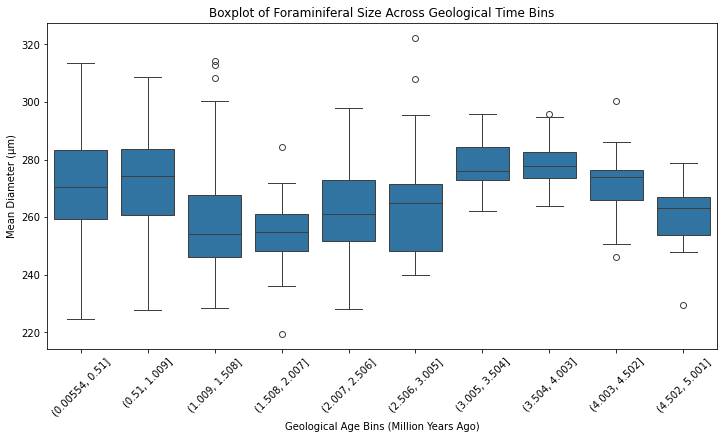

In [21]:
plt.figure(figsize=(12, 6))
sns.boxplot(x=pd.cut(data["Age (Ma)"], bins=10), y=data["Mean (Diameter) (µm)"])
plt.xticks(rotation=45)
plt.title("Boxplot of Foraminiferal Size Across Geological Time Bins")
plt.xlabel("Geological Age Bins (Million Years Ago)")
plt.ylabel("Mean Diameter (µm)")
plt.show()


In [22]:
plt.figure(figsize=(12, 6))
sns.boxplot(x=pd.cut(data2["Age (Ma)"], bins=10), y=data["Mean (Diameter) (µm)"])
plt.xticks(rotation=45)
plt.title("Boxplot of Foraminiferal Size Across Geological Time Bins")
plt.xlabel("Geological Age Bins (Million Years Ago)")
plt.ylabel("Mean Diameter (µm)")
plt.show()


NameError: name 'data2' is not defined

<Figure size 864x432 with 0 Axes>

In [23]:
from scipy.stats import skew, kurtosis

# Group data into geological age bins
distribution_stats = data.groupby(pd.cut(data["Age (Ma)"], bins=10)).agg({
    "Mean (Diameter) (µm)": ['mean', 'median', 'var', skew, kurtosis]
}).reset_index()

# Rename columns for clarity
distribution_stats.columns = ['Age Group', 'Mean', 'Median', 'Variance', 'Skewness', 'Kurtosis']

# Display results
print(distribution_stats)


         Age Group        Mean      Median    Variance  Skewness  Kurtosis
0  (0.00554, 0.51]  271.702013  270.656129  300.754437  0.048106 -0.357883
1    (0.51, 1.009]  272.630788  274.297565  277.515341 -0.175991 -0.304514
2   (1.009, 1.508]  258.923090  254.023194  380.404986  0.911812  0.341189
3   (1.508, 2.007]  254.207012  254.746416  118.982443 -0.238948  1.517889
4   (2.007, 2.506]  261.966950  261.030208  231.180753  0.178977 -0.408128
5   (2.506, 3.005]  264.750663  264.974735  364.397014  1.092062  1.255235
6   (3.005, 3.504]  278.323629  275.909144   98.085635  0.452502 -0.763753
7   (3.504, 4.003]  278.728471  277.649197   58.408736  0.614962  0.428052
8   (4.003, 4.502]  271.648890  273.901264  154.663790 -0.048511  0.618615
9   (4.502, 5.001]  259.930495  263.148876  128.344226 -1.020725  1.391274


/var/folders/jt/0lv95mcn7f784lx7z_pw70tc0000gn/T/ipykernel_9151/3067988006.py:4: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  distribution_stats = data.groupby(pd.cut(data["Age (Ma)"], bins=10)).agg({


In [ ]:
from scipy.stats import skew, kurtosis

# Group data into geological age bins
distribution_stats = data2.groupby(pd.cut(data2["Age (Ma)"], bins=10)).agg({
    "Mean (Diameter) (µm)": ['mean', 'median', 'var', skew, kurtosis]
}).reset_index()

# Rename columns for clarity
distribution_stats.columns = ['Age Group', 'Mean', 'Median', 'Variance', 'Skewness', 'Kurtosis']

# Display results
print(distribution_stats)


/var/folders/jt/0lv95mcn7f784lx7z_pw70tc0000gn/T/ipykernel_9151/959290741.py:4: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  signal = data["Mean (Diameter) (µm)"].fillna(method='bfill').values


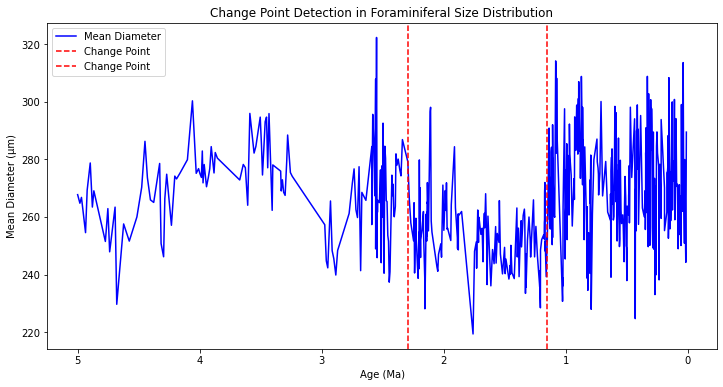

In [24]:
import ruptures as rpt

# Extract signal for change point detection
signal = data["Mean (Diameter) (µm)"].fillna(method='bfill').values

# Apply change point detection (PELT Algorithm)
algo = rpt.Pelt(model="rbf").fit(signal)
change_points = algo.predict(pen=5)

# Ensure Change Points Are Within Valid Index Range
valid_change_points = [cp for cp in change_points if cp < len(data)]

# Plot results
plt.figure(figsize=(12, 6))
plt.plot(data["Age (Ma)"], data["Mean (Diameter) (µm)"], label="Mean Diameter", color="blue")

for cp in valid_change_points:
    plt.axvline(x=data["Age (Ma)"].iloc[cp], color='red', linestyle='dashed', label="Change Point")

plt.gca().invert_xaxis()  # Geological time runs backward
plt.title("Change Point Detection in Foraminiferal Size Distribution")
plt.xlabel("Age (Ma)")
plt.ylabel("Mean Diameter (µm)")
plt.legend()
plt.show()


In [ ]:
import ruptures as rpt

# Extract signal for change point detection
signal = data2["Mean (Diameter) (µm)"].fillna(method='bfill').values

# Apply change point detection (PELT Algorithm)
algo = rpt.Pelt(model="rbf").fit(signal)
change_points = algo.predict(pen=5)

# Ensure Change Points Are Within Valid Index Range
valid_change_points = [cp for cp in change_points if cp < len(data2)]

# Plot results
plt.figure(figsize=(12, 6))
plt.plot(data2["Age (Ma)"], data2["Mean (Diameter) (µm)"], label="Mean Diameter", color="blue")

for cp in valid_change_points:
    plt.axvline(x=data2["Age (Ma)"].iloc[cp], color='red', linestyle='dashed', label="Change Point")

plt.gca().invert_xaxis()  # Geological time runs backward
plt.title("Change Point Detection in Foraminiferal Size Distribution")
plt.xlabel("Age (Ma)")
plt.ylabel("Mean Diameter (µm)")
plt.legend()
plt.show()


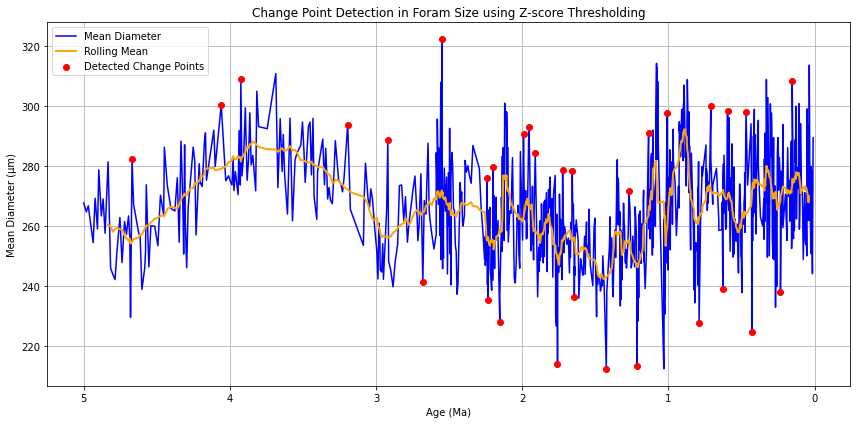

In [25]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Load data
data = pd.read_csv("analyzer_data.csv")  # Replace with your filename
data = data.sort_values("Age (Ma)", ascending=False).reset_index(drop=True)

# Compute rolling mean and std deviation
window_size = 20
data["rolling_mean"] = data["Mean (Diameter) (µm)"].rolling(window=window_size, center=True).mean()
data["rolling_std"] = data["Mean (Diameter) (µm)"].rolling(window=window_size, center=True).std()

# Compute Z-score to detect shifts
data["z_score"] = (data["Mean (Diameter) (µm)"] - data["rolling_mean"]) / data["rolling_std"]

# Set threshold to mark change points
z_thresh = 2.0
data["change_point"] = data["z_score"].abs() > z_thresh

# Plot the results
plt.figure(figsize=(12, 6))
plt.plot(data["Age (Ma)"], data["Mean (Diameter) (µm)"], label="Mean Diameter", color="blue")
plt.plot(data["Age (Ma)"], data["rolling_mean"], label="Rolling Mean", color="orange", linewidth=2)
plt.scatter(
    data.loc[data["change_point"], "Age (Ma)"],
    data.loc[data["change_point"], "Mean (Diameter) (µm)"],
    color="red", label="Detected Change Points", zorder=5
)
plt.gca().invert_xaxis()
plt.xlabel("Age (Ma)")
plt.ylabel("Mean Diameter (µm)")
plt.title("Change Point Detection in Foram Size using Z-score Thresholding")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [27]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import seaborn as sns

features = ['Mean (Diameter) (µm)', 'Elongation', 'Sphericity', 'Shape Factor', 'Area (µm²)', 'Perimeter (µm)']
X = data[features].dropna()
X_scaled = StandardScaler().fit_transform(X)
pca = PCA(n_components=2)
pca_components = pca.fit_transform(X_scaled)

pca_df = pd.DataFrame(data=pca_components, columns=['PC1', 'PC2'])
pca_df['Age (Ma)'] = data.loc[X.index, 'Age (Ma)']
pca_df['Age Bin'] = pd.cut(pca_df['Age (Ma)'], bins=10)

plt.figure(figsize=(10, 6))
sns.scatterplot(data=pca_df, x='PC1', y='PC2', hue='Age Bin', palette='Spectral', s=50, edgecolor='k', alpha=0.8)
plt.title('PCA Morphospace of Foraminiferal Shapes Colored by Age Bin')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend(title='Age Bin', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()


KeyError: "['Elongation', 'Area (µm²)', 'Perimeter (µm)'] not in index"

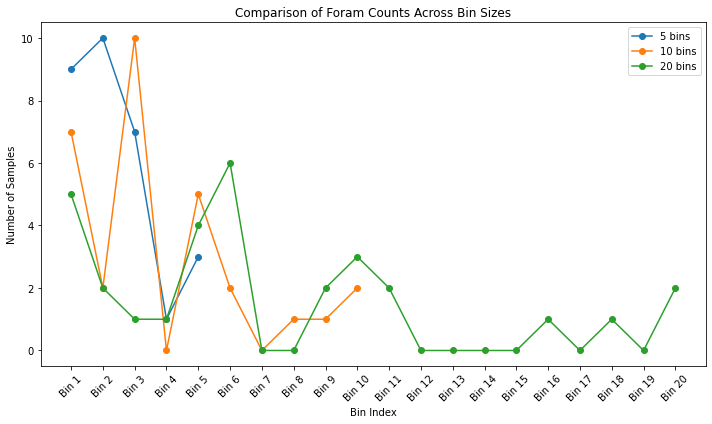

In [28]:
import pandas as pd
import matplotlib.pyplot as plt

bin_sizes = [5, 10, 20]
plt.figure(figsize=(10, 6))

for bins in bin_sizes:
    data[f'bin_{bins}'] = pd.cut(data['Age (Ma)'], bins=bins)
    bin_counts = data[f'bin_{bins}'].value_counts().sort_index()
    plt.plot(range(len(bin_counts)), bin_counts.values, label=f"{bins} bins", marker='o')

plt.xticks(range(len(bin_counts)), [f"Bin {i+1}" for i in range(len(bin_counts))], rotation=45)
plt.title("Comparison of Foram Counts Across Bin Sizes")
plt.xlabel("Bin Index")
plt.ylabel("Number of Samples")
plt.legend()
plt.tight_layout()
plt.show()


In [ ]:
!pip install seaborn --upgrade


   year    mean   unc
0  1959  315.98  0.12
1  1960  316.91  0.12
2  1961  317.64  0.12
3  1962  318.45  0.12
4  1963  318.99  0.12


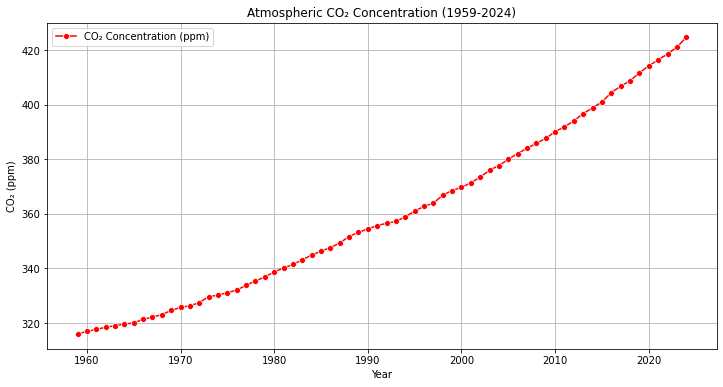

In [29]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load dataset
co2_data = pd.read_csv("co2_annmean_mlo.csv", comment='#')  # Ignore metadata lines

# Display first few rows
print(co2_data.head())

# Plot CO₂ trend over time
plt.figure(figsize=(12, 6))
sns.lineplot(x=co2_data["year"], y=co2_data["mean"], marker="o", color="red", label="CO₂ Concentration (ppm)")
plt.xlabel("Year")
plt.ylabel("CO₂ (ppm)")
plt.title("Atmospheric CO₂ Concentration (1959-2024)")
plt.grid(True)
plt.legend()
plt.show()


Average Annual CO₂ Growth Rate: 1.67 ppm/year


/var/folders/jt/0lv95mcn7f784lx7z_pw70tc0000gn/T/ipykernel_9151/650796208.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=co2_data["year"], y=co2_data["annual_change"], palette="coolwarm")


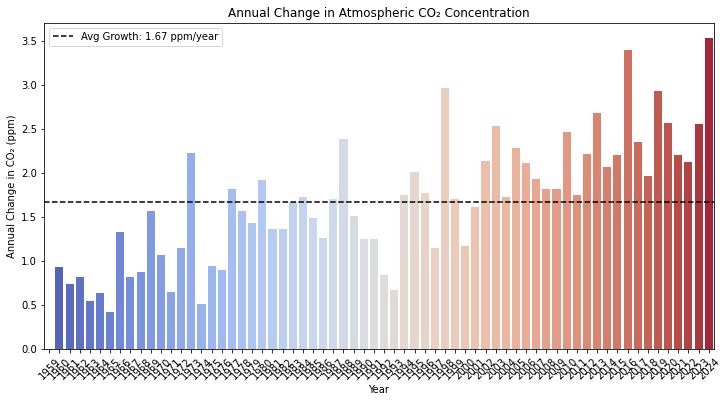

In [30]:
# Compute annual change in CO₂ concentration
co2_data["annual_change"] = co2_data["mean"].diff()

# Compute average annual growth rate
avg_growth_rate = co2_data["annual_change"].mean()
print(f"Average Annual CO₂ Growth Rate: {avg_growth_rate:.2f} ppm/year")

# Visualize annual change
plt.figure(figsize=(12, 6))
sns.barplot(x=co2_data["year"], y=co2_data["annual_change"], palette="coolwarm")
plt.axhline(avg_growth_rate, color="black", linestyle="dashed", label=f"Avg Growth: {avg_growth_rate:.2f} ppm/year")
plt.xlabel("Year")
plt.ylabel("Annual Change in CO₂ (ppm)")
plt.title("Annual Change in Atmospheric CO₂ Concentration")
plt.xticks(rotation=45)
plt.legend()
plt.show()


In [31]:
# Detect anomalies where annual change exceeds 2 standard deviations
threshold = co2_data["annual_change"].mean() + 2 * co2_data["annual_change"].std()
anomalies = co2_data[co2_data["annual_change"] > threshold]

print("Major CO₂ Anomalies:\n", anomalies)


Major CO₂ Anomalies:
     year    mean   unc  annual_change
57  2016  404.41  0.12           3.40
65  2024  424.61  0.12           3.53


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'


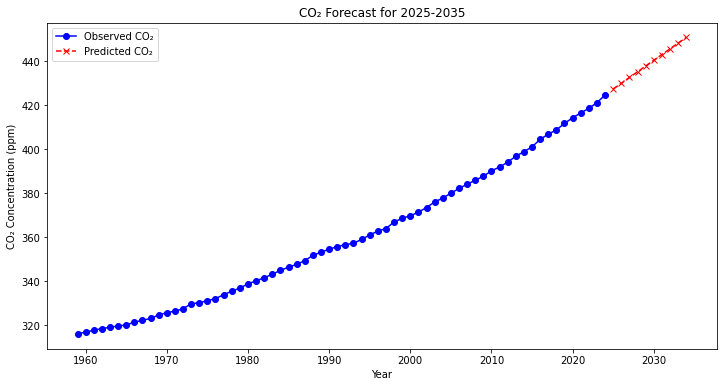

In [32]:
from statsmodels.tsa.arima.model import ARIMA

# Fit ARIMA Model
model = ARIMA(co2_data["mean"], order=(2,1,2))
model_fit = model.fit()

# Forecast next 10 years
forecast = model_fit.forecast(steps=10)

# Create future year index
future_years = list(range(2025, 2035))

# Plot predictions
plt.figure(figsize=(12, 6))
plt.plot(co2_data["year"], co2_data["mean"], label="Observed CO₂", marker="o", color="blue")
plt.plot(future_years, forecast, label="Predicted CO₂", marker="x", linestyle="dashed", color="red")
plt.xlabel("Year")
plt.ylabel("CO₂ Concentration (ppm)")
plt.title("CO₂ Forecast for 2025-2035")
plt.legend()
plt.show()


In [33]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Load data
co2_data = pd.read_csv("co2_annmean_mlo.csv", comment="#")  # Ignore header comments
foram_data = pd.read_csv("analyzer_data.csv")

# Standardize column names
co2_data.columns = co2_data.columns.str.strip()
foram_data.columns = foram_data.columns.str.strip()

# Merge on Year (Age in Ma converted to modern scale)
merged_data = pd.merge(foram_data, co2_data, left_on="Age (Ma)", right_on="year", how="inner")

# Compute correlation
corr_matrix = merged_data[["Mean (Diameter) (µm)", "CO₂(ppm)"]].corr()

# Visualize correlation
plt.figure(figsize=(8, 6))
sns.heatmap(corr_matrix, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Correlation Between Foraminiferal Size & CO₂ Levels")
plt.show()


/var/folders/jt/0lv95mcn7f784lx7z_pw70tc0000gn/T/ipykernel_9151/3206128325.py:14: UserWarning: You are merging on int and float columns where the float values are not equal to their int representation.
  merged_data = pd.merge(foram_data, co2_data, left_on="Age (Ma)", right_on="year", how="inner")


KeyError: "['CO₂(ppm)'] not in index"

In [34]:
# Rename CO₂ column for consistency
co2_data.rename(columns={"mean": "CO2_ppm"}, inplace=True)

# Merge datasets on Year (Age in Ma rounded)
merged_data = pd.merge(foram_data, co2_data, left_on="Age (Ma)", right_on="year", how="inner")

# Verify merged columns
print("Merged Data Columns:", merged_data.columns)


Merged Data Columns: Index(['Min (Diameter) (µm)', 'Max (Diameter) (µm)', 'Mean (Diameter) (µm)',
       'Elongation', 'Sphericity', 'Shape Factor',
       'Mean (Gray Intensity Value)', 'Age (Ma)', 'FILE_NAME', 'Area (µm²)',
       'Perimeter (µm)', 'year', 'CO2_ppm', 'unc'],
      dtype='object')


/var/folders/jt/0lv95mcn7f784lx7z_pw70tc0000gn/T/ipykernel_9151/501916613.py:5: UserWarning: You are merging on int and float columns where the float values are not equal to their int representation.
  merged_data = pd.merge(foram_data, co2_data, left_on="Age (Ma)", right_on="year", how="inner")


In [35]:
print("CO₂ Data Columns:", co2_data.columns)
print("Foraminiferal Data Columns:", foram_data.columns)


CO₂ Data Columns: Index(['year', 'CO2_ppm', 'unc'], dtype='object')
Foraminiferal Data Columns: Index(['Min (Diameter) (µm)', 'Max (Diameter) (µm)', 'Mean (Diameter) (µm)',
       'Elongation', 'Sphericity', 'Shape Factor',
       'Mean (Gray Intensity Value)', 'Age (Ma)', 'FILE_NAME', 'Area (µm²)',
       'Perimeter (µm)'],
      dtype='object')


In [36]:
# Convert 'year' column in CO₂ data to float for precise merging
co2_data["year"] = co2_data["year"].astype(float)

# Perform the merge
merged_data = pd.merge(foram_data, co2_data, left_on="Age (Ma)", right_on="year", how="inner")

# Verify column names
print("Merged Data Columns:", merged_data.columns)


Merged Data Columns: Index(['Min (Diameter) (µm)', 'Max (Diameter) (µm)', 'Mean (Diameter) (µm)',
       'Elongation', 'Sphericity', 'Shape Factor',
       'Mean (Gray Intensity Value)', 'Age (Ma)', 'FILE_NAME', 'Area (µm²)',
       'Perimeter (µm)', 'year', 'CO2_ppm', 'unc'],
      dtype='object')


In [37]:
print("Available Columns in Merged Data:", merged_data.columns)


Available Columns in Merged Data: Index(['Min (Diameter) (µm)', 'Max (Diameter) (µm)', 'Mean (Diameter) (µm)',
       'Elongation', 'Sphericity', 'Shape Factor',
       'Mean (Gray Intensity Value)', 'Age (Ma)', 'FILE_NAME', 'Area (µm²)',
       'Perimeter (µm)', 'year', 'CO2_ppm', 'unc'],
      dtype='object')


In [38]:
co2_data.rename(columns={"mean": "CO2_ppm"}, inplace=True)


In [39]:
merged_data = pd.merge(foram_data, co2_data, left_on="Age (Ma)", right_on="year", how="inner")


In [40]:
print("After Merging, Columns Are:", merged_data.columns)


After Merging, Columns Are: Index(['Min (Diameter) (µm)', 'Max (Diameter) (µm)', 'Mean (Diameter) (µm)',
       'Elongation', 'Sphericity', 'Shape Factor',
       'Mean (Gray Intensity Value)', 'Age (Ma)', 'FILE_NAME', 'Area (µm²)',
       'Perimeter (µm)', 'year', 'CO2_ppm', 'unc'],
      dtype='object')


In [41]:
# Check if the data contains NaN or unexpected values
print(merged_data[["Age (Ma)", "Mean (Diameter) (µm)", "CO2_ppm"]].describe())

# Check if columns are numeric
print(merged_data.dtypes)


       Age (Ma)  Mean (Diameter) (µm)  CO2_ppm
count       0.0                   0.0      0.0
mean        NaN                   NaN      NaN
std         NaN                   NaN      NaN
min         NaN                   NaN      NaN
25%         NaN                   NaN      NaN
50%         NaN                   NaN      NaN
75%         NaN                   NaN      NaN
max         NaN                   NaN      NaN
Min (Diameter) (µm)            float64
Max (Diameter) (µm)            float64
Mean (Diameter) (µm)           float64
Elongation                     float64
Sphericity                     float64
Shape Factor                   float64
Mean (Gray Intensity Value)    float64
Age (Ma)                       float64
FILE_NAME                       object
Area (µm²)                     float64
Perimeter (µm)                 float64
year                           float64
CO2_ppm                        float64
unc                            float64
dtype: object


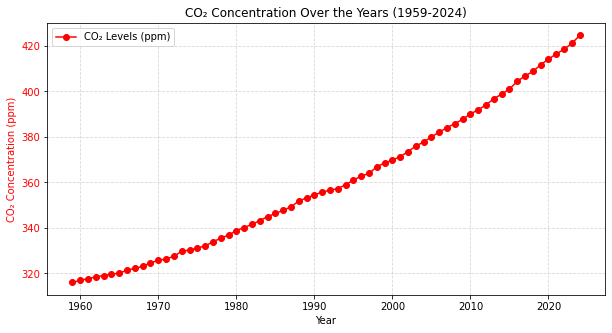

In [42]:
import matplotlib.pyplot as plt

# CO2 data from 1959 to 2024
years = list(range(1959, 2025))
co2_levels = [
    315.98, 316.91, 317.64, 318.45, 318.99, 319.62, 320.04, 321.37, 322.18, 323.05,
    324.62, 325.68, 326.32, 327.46, 329.68, 330.19, 331.13, 332.03, 333.84, 335.41,
    336.84, 338.76, 340.12, 341.48, 343.15, 344.87, 346.35, 347.61, 349.31, 351.69,
    353.20, 354.45, 355.70, 356.54, 357.21, 358.96, 360.97, 362.74, 363.88, 366.84,
    368.54, 369.71, 371.32, 373.45, 375.98, 377.70, 379.98, 382.09, 384.02, 385.83,
    387.64, 390.10, 391.85, 394.06, 396.74, 398.81, 401.01, 404.41, 406.76, 408.72,
    411.65, 414.21, 416.41, 418.53, 421.08, 424.61
]

# Create figure and axis
fig, ax1 = plt.subplots(figsize=(10, 5))

# Plot CO2 levels on the left y-axis
ax1.plot(years, co2_levels, color='red', marker='o', linestyle='-', label='CO₂ Levels (ppm)')
ax1.set_xlabel('Year')
ax1.set_ylabel('CO₂ Concentration (ppm)', color='red')
ax1.tick_params(axis='y', labelcolor='red')

# Title and legend
plt.title('CO₂ Concentration Over the Years (1959-2024)')
ax1.legend(loc='upper left')

# Show the plot
plt.grid(True, linestyle="--", alpha=0.5)
plt.show()


In [43]:
print(co2_data.columns)


Index(['year', 'CO2_ppm', 'unc'], dtype='object')


In [44]:
co2_data.columns = co2_data.columns.str.strip().str.lower()


In [45]:
print(co2_data.columns)


Index(['year', 'co2_ppm', 'unc'], dtype='object')


In [46]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import skew

# Load foram size dataset
foram_data = pd.read_csv("analyzer_data.csv")  # Replace with your actual file

# Load CO₂ dataset
co2_data = pd.read_csv("co2_annmean_mlo.csv", comment='#')


# Merge datasets on the common "year" column
merged_data = pd.merge(foram_data, co2_data, on="year", how="inner")

# Grouping by decades for better visualization
merged_data["decade"] = (merged_data["year"] // 10) * 10

# Plot KDE (Kernel Density Estimation) to visualize distribution shape changes
plt.figure(figsize=(12, 6))
sns.kdeplot(data=merged_data, x="foram_size", hue="decade", fill=True, common_norm=False, palette="coolwarm")
plt.xlabel("Foraminiferal Size (µm)")
plt.ylabel("Density")
plt.title("Change in Size Distribution Over Time")
plt.legend(title="Decade")
plt.show()

# Calculate skewness over time
skewness_data = merged_data.groupby("year")["foram_size"].apply(skew).reset_index()
plt.figure(figsize=(12, 6))
sns.lineplot(data=skewness_data, x="year", y="foram_size", marker="o", color="blue", label="Skewness")
plt.axhline(0, linestyle="--", color="red", alpha=0.7)
plt.xlabel("Year")
plt.ylabel("Skewness of Foram Size")
plt.title("Skewness Change in Size Distribution Over Time")
plt.legend()
plt.show()


KeyError: 'year'

In [47]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import skew, kurtosis

# Load Foram Data
foram_data = pd.read_csv("analyzer_data.csv")

# Load CO₂ Data (handling header issues)
co2_data = pd.read_csv("co2_annmean_mlo.csv", comment="#")  # Skips NOAA metadata lines

# Rename CO₂ column for consistency
co2_data.rename(columns={"mean": "CO2_ppm"}, inplace=True)

# Ensure "year" column is in correct type
foram_data["Age (Ma)"] = foram_data["Age (Ma)"].astype(float)  # Geological age
co2_data["year"] = co2_data["year"].astype(float)

# Merge Data on closest matching ages (Geological Age ↔ Year)
merged_data = foram_data.merge(co2_data, left_on="Age (Ma)", right_on="year", how="inner")

# Drop redundant year column after merge
merged_data.drop(columns=["year"], inplace=True)

print("🔹 Merged Data Columns:", merged_data.columns)


🔹 Merged Data Columns: Index(['Min (Diameter) (µm)', 'Max (Diameter) (µm)', 'Mean (Diameter) (µm)',
       'Elongation', 'Sphericity', 'Shape Factor',
       'Mean (Gray Intensity Value)', 'Age (Ma)', 'FILE_NAME', 'Area (µm²)',
       'Perimeter (µm)', 'CO2_ppm', 'unc'],
      dtype='object')


In [48]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import skew, kurtosis

# Load Foram Data
foram_data2 = pd.read_csv("result.csv")

# Load CO₂ Data (handling header issues)
co2_data = pd.read_csv("co2_annmean_mlo.csv", comment="#")  # Skips NOAA metadata lines

# Rename CO₂ column for consistency
co2_data.rename(columns={"mean": "CO2_ppm"}, inplace=True)

# Ensure "year" column is in correct type
foram_data["Age (Ma)"] = foram_data["Age (Ma)"].astype(float)  # Geological age
co2_data["year"] = co2_data["year"].astype(float)

# Merge Data on closest matching ages (Geological Age ↔ Year)
merged_data = foram_data.merge(co2_data, left_on="Age (Ma)", right_on="year", how="inner")

# Drop redundant year column after merge
merged_data.drop(columns=["year"], inplace=True)

print("🔹 Merged Data Columns:", merged_data.columns)


FileNotFoundError: [Errno 2] No such file or directory: 'result.csv'

In [49]:
plt.figure(figsize=(12, 6))
sns.kdeplot(data=merged_data, x="Mean (Diameter) (µm)", hue=pd.cut(merged_data["Age (Ma)"], bins=10), fill=True, common_norm=False, palette="coolwarm")
plt.xlabel("Foraminiferal Size (µm)", fontsize=12)
plt.ylabel("Density", fontsize=12)
plt.title("Changes in Foram Size Distribution Over Time", fontsize=14)
plt.legend(title="Geological Age Bins")
plt.show()


ValueError: Cannot cut empty array

<Figure size 864x432 with 0 Axes>

In [50]:
# Compute skewness & kurtosis for each time bin
distribution_stats = merged_data.groupby(pd.cut(merged_data["Age (Ma)"], bins=10))["Mean (Diameter) (µm)"].agg(["mean", "var", skew, kurtosis]).reset_index()
distribution_stats.columns = ["Age Group", "Mean Size", "Variance", "Skewness", "Kurtosis"]
print(distribution_stats)

# Skewness & Kurtosis Plot
fig, ax1 = plt.subplots(figsize=(12, 6))

# Skewness (Left Y-Axis)
ax1.plot(distribution_stats["Age Group"].astype(str), distribution_stats["Skewness"], color="blue", marker="o", label="Skewness")
ax1.set_xlabel("Geological Age Group", fontsize=12)
ax1.set_ylabel("Skewness", color="blue")
ax1.tick_params(axis="y", labelcolor="blue")

# Kurtosis (Right Y-Axis)
ax2 = ax1.twinx()
ax2.plot(distribution_stats["Age Group"].astype(str), distribution_stats["Kurtosis"], color="red", linestyle="dashed", marker="x", label="Kurtosis")
ax2.set_ylabel("Kurtosis", color="red")
ax2.tick_params(axis="y", labelcolor="red")

plt.title("Skewness & Kurtosis of Foram Size Over Time", fontsize=14)
fig.legend(loc="upper left", bbox_to_anchor=(0.1, 0.9))
plt.xticks(rotation=45)
plt.show()


ValueError: Cannot cut empty array

In [51]:
# Check if merged_data is empty
if merged_data.empty:
    print("⚠️ Merged dataset is empty! Check the merging process.")
else:
    print("✅ Merged dataset contains data.")

# Check for missing values in required columns
print(merged_data[["Age (Ma)", "Mean (Diameter) (µm)"]].isnull().sum())


⚠️ Merged dataset is empty! Check the merging process.
Age (Ma)                0
Mean (Diameter) (µm)    0
dtype: int64


In [52]:
print("Foraminiferal Data Columns:", foram_data.columns)
print("CO₂ Data Columns:", co2_data.columns)


Foraminiferal Data Columns: Index(['Min (Diameter) (µm)', 'Max (Diameter) (µm)', 'Mean (Diameter) (µm)',
       'Elongation', 'Sphericity', 'Shape Factor',
       'Mean (Gray Intensity Value)', 'Age (Ma)', 'FILE_NAME', 'Area (µm²)',
       'Perimeter (µm)'],
      dtype='object')
CO₂ Data Columns: Index(['year', 'CO2_ppm', 'unc'], dtype='object')


In [53]:
print(foram_data.dtypes)
print(co2_data.dtypes)


Min (Diameter) (µm)            float64
Max (Diameter) (µm)            float64
Mean (Diameter) (µm)           float64
Elongation                     float64
Sphericity                     float64
Shape Factor                   float64
Mean (Gray Intensity Value)    float64
Age (Ma)                       float64
FILE_NAME                       object
Area (µm²)                     float64
Perimeter (µm)                 float64
dtype: object
year       float64
CO2_ppm    float64
unc        float64
dtype: object


In [54]:
print(foram_data2.dtypes)
print(co2_data.dtypes)


NameError: name 'foram_data2' is not defined

In [55]:
foram_data["Age (Ma)"] = foram_data["Age (Ma)"].round().astype(int)  # Round ages to match integer years
co2_data["year"] = co2_data["year"].astype(int)  # Ensure year is also int


In [56]:
merged_data = pd.merge(foram_data, co2_data, left_on="Age (Ma)", right_on="year", how="inner")


In [57]:
merged_data = foram_data.merge(co2_data, left_on="Age (Ma)", right_on="year", how="left")


In [58]:
print("Unique rounded Ages in Foram Data:", foram_data["Age (Ma)"].unique())
print("Unique Years in CO₂ Data:", co2_data["year"].unique())


Unique rounded Ages in Foram Data: [3 0 1 4 5 2]
Unique Years in CO₂ Data: [1959 1960 1961 1962 1963 1964 1965 1966 1967 1968 1969 1970 1971 1972
 1973 1974 1975 1976 1977 1978 1979 1980 1981 1982 1983 1984 1985 1986
 1987 1988 1989 1990 1991 1992 1993 1994 1995 1996 1997 1998 1999 2000
 2001 2002 2003 2004 2005 2006 2007 2008 2009 2010 2011 2012 2013 2014
 2015 2016 2017 2018 2019 2020 2021 2022 2023 2024]


In [59]:
foram_data["Year"] = 2024 - foram_data["Age (Ma)"]


In [60]:
merged_data = pd.merge(foram_data, co2_data, left_on="Year", right_on="year", how="inner")


In [61]:
print(merged_data.head())
print("✅ Merge successful! Data available." if not merged_data.empty else "⚠️ Still empty. Check conversions.")


   Min (Diameter) (µm)  Max (Diameter) (µm)  Mean (Diameter) (µm)  Elongation  \
0           234.058791           310.492502            276.683537    2.212517   
1           225.208193           293.834504            262.504316    2.204742   
2           221.175131           293.062145            261.191124    2.207175   
3           217.034087           284.816053            254.663748    2.208939   
4           226.788060           306.396886            271.659771    2.222252   

   Sphericity  Shape Factor  Mean (Gray Intensity Value)  Age (Ma)  \
0    1.687675      1.795725                   115.994398         3   
1    1.695729      1.806127                   104.970615         3   
2    1.693180      1.791775                   113.233041         3   
3    1.691388      1.809358                   101.242530         3   
4    1.677056      1.787538                   119.642388         3   

                 FILE_NAME    Area (µm²)  Perimeter (µm)  Year  year  CO2_ppm  \
0  925B,10H

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


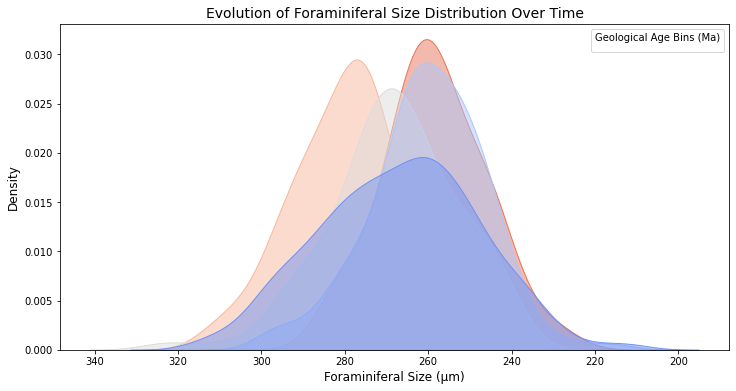

In [62]:
plt.figure(figsize=(12, 6))
sns.kdeplot(data=merged_data, x="Mean (Diameter) (µm)", hue=pd.cut(merged_data["Age (Ma)"], bins=5), 
            fill=True, common_norm=False, palette="coolwarm", alpha=0.5)
plt.xlabel("Foraminiferal Size (µm)", fontsize=12)
plt.ylabel("Density", fontsize=12)
plt.title("Evolution of Foraminiferal Size Distribution Over Time", fontsize=14)
plt.legend(title="Geological Age Bins (Ma)")
plt.gca().invert_xaxis()  # Geological time runs backward
plt.show()


/var/folders/jt/0lv95mcn7f784lx7z_pw70tc0000gn/T/ipykernel_9151/1558649224.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(data=merged_data, x=pd.cut(merged_data["Age (Ma)"], bins=5), y="Mean (Diameter) (µm)", palette="coolwarm")


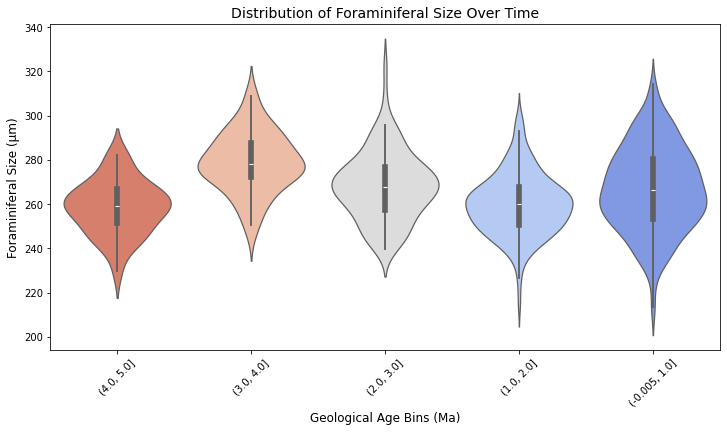

In [63]:
plt.figure(figsize=(12, 6))
sns.violinplot(data=merged_data, x=pd.cut(merged_data["Age (Ma)"], bins=5), y="Mean (Diameter) (µm)", palette="coolwarm")
plt.xlabel("Geological Age Bins (Ma)", fontsize=12)
plt.ylabel("Foraminiferal Size (µm)", fontsize=12)
plt.title("Distribution of Foraminiferal Size Over Time", fontsize=14)
plt.xticks(rotation=45)
plt.gca().invert_xaxis()
plt.show()


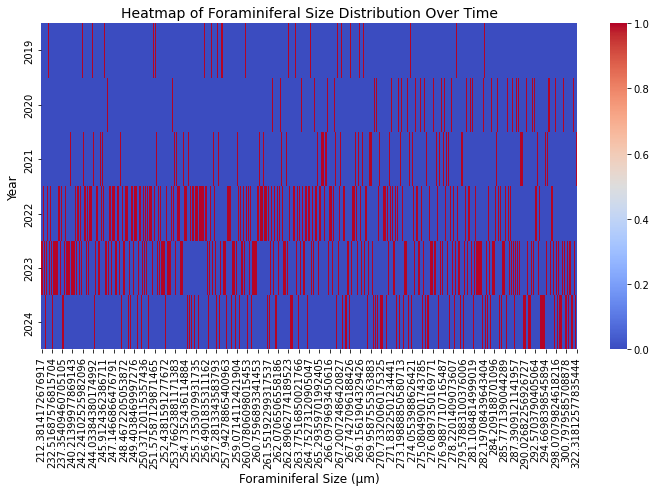

In [64]:
plt.figure(figsize=(12, 6))
heatmap_data = merged_data.pivot_table(index="Year", columns="Mean (Diameter) (µm)", values="CO2_ppm", aggfunc="count").fillna(0)
sns.heatmap(heatmap_data, cmap="coolwarm", cbar=True)
plt.xlabel("Foraminiferal Size (µm)", fontsize=12)
plt.ylabel("Year", fontsize=12)
plt.title("Heatmap of Foraminiferal Size Distribution Over Time", fontsize=14)
plt.show()


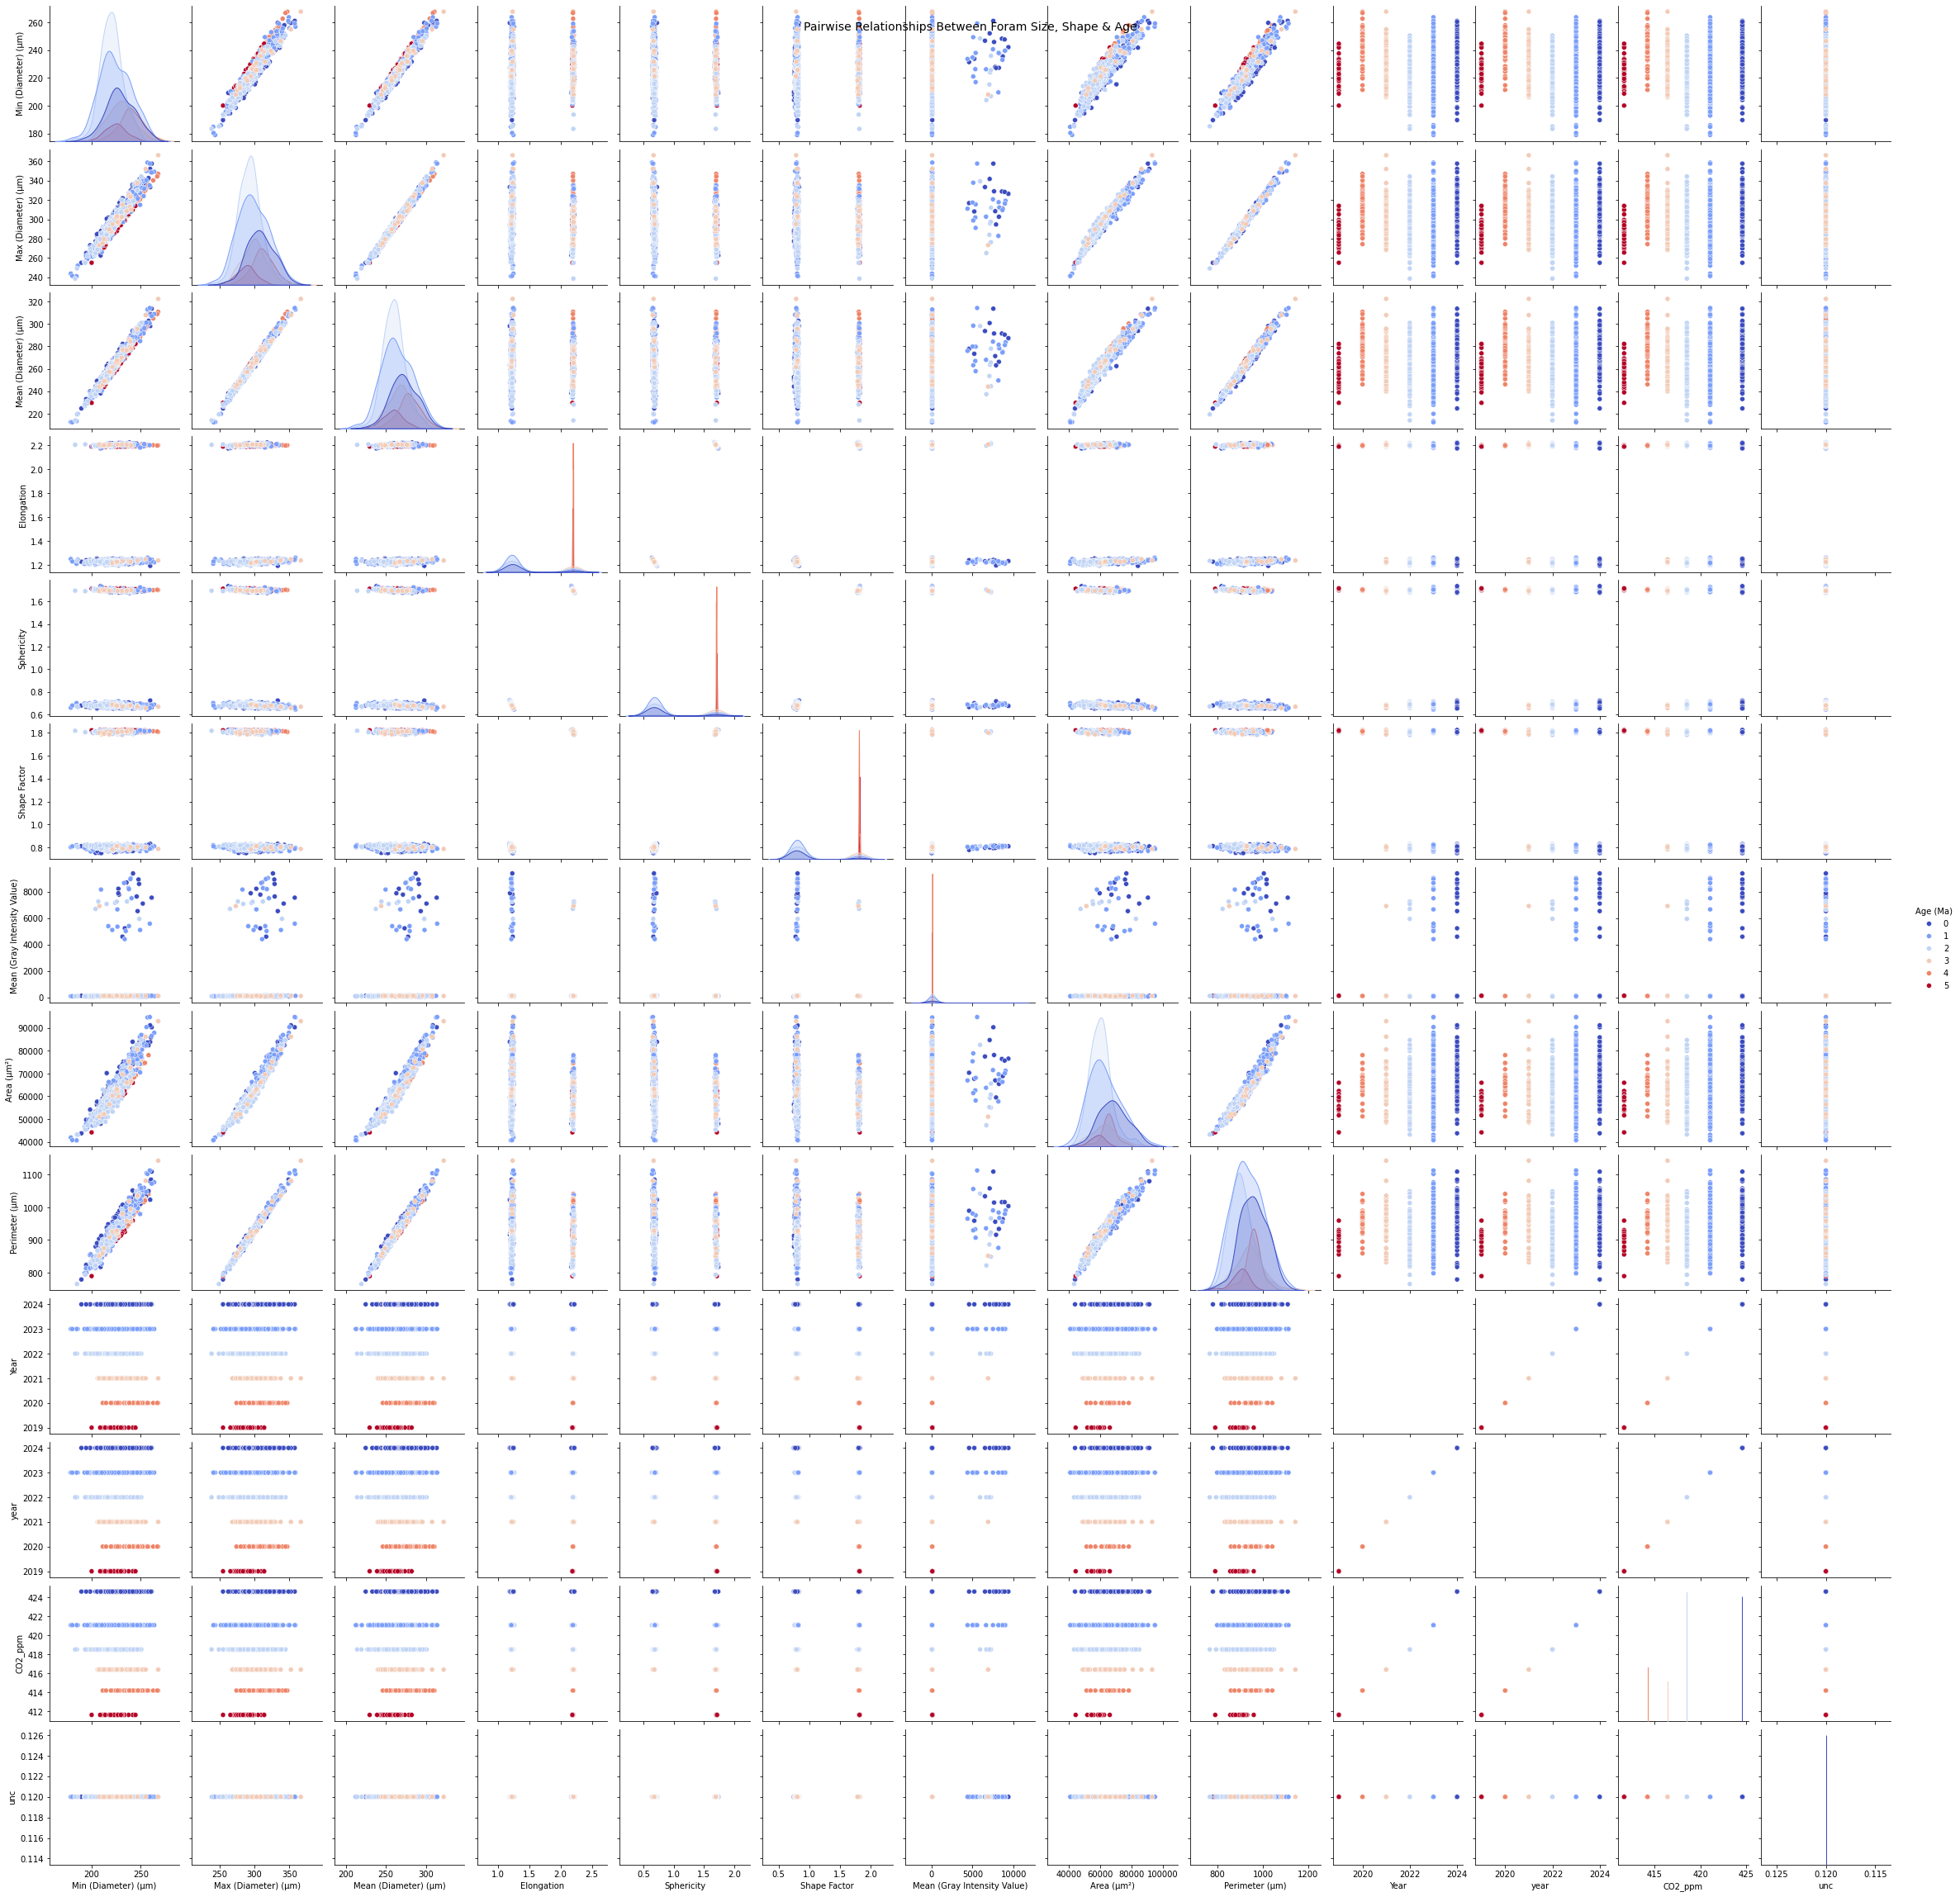

In [65]:
sns.pairplot(merged_data, hue="Age (Ma)", diag_kind="kde", palette="coolwarm")
plt.suptitle("Pairwise Relationships Between Foram Size, Shape & Age", fontsize=14)
plt.gca().invert_xaxis()
plt.show()


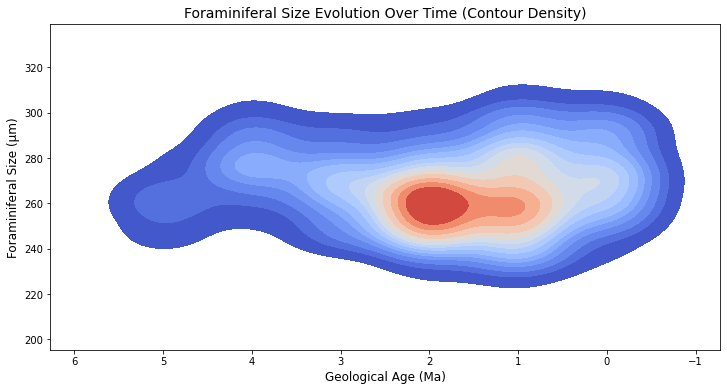

In [66]:
plt.figure(figsize=(12, 6))
sns.kdeplot(data=merged_data, x="Age (Ma)", y="Mean (Diameter) (µm)", fill=True, cmap="coolwarm", levels=15)
plt.xlabel("Geological Age (Ma)", fontsize=12)
plt.ylabel("Foraminiferal Size (µm)", fontsize=12)
plt.title("Foraminiferal Size Evolution Over Time (Contour Density)", fontsize=14)
plt.gca().invert_xaxis()  # Reverse time axis
plt.show()


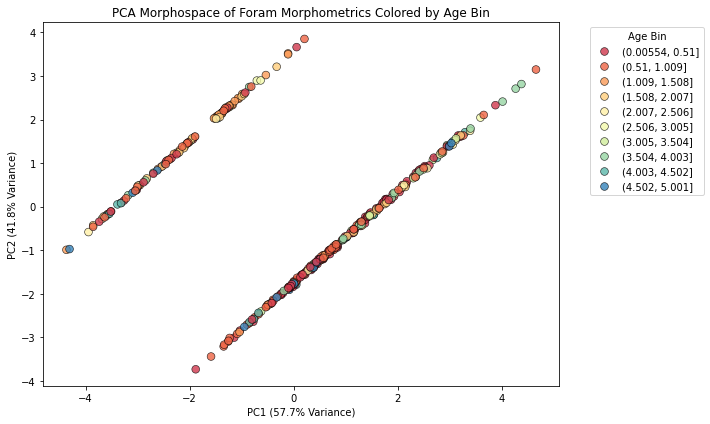

In [67]:
import pandas as pd
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns

# Load data
df = pd.read_csv('analyzer_data.csv')

# Select relevant morphometric features for PCA
features = ['Mean (Diameter) (µm)', 'Elongation', 'Sphericity', 
            'Shape Factor', 'Area (µm²)', 'Perimeter (µm)']

# Drop rows with missing values in these columns
df_clean = df.dropna(subset=features)

# Standardize features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(df_clean[features])

# Run PCA
pca = PCA(n_components=2)
pca_components = pca.fit_transform(X_scaled)

# Create DataFrame for plotting
pca_df = pd.DataFrame(data=pca_components, columns=['PC1', 'PC2'])
pca_df['Age (Ma)'] = df_clean['Age (Ma)']

# Optional: create age bins
pca_df['Age Bin'] = pd.cut(pca_df['Age (Ma)'], bins=10)

# Plot PCA
plt.figure(figsize=(10, 6))
sns.scatterplot(data=pca_df, x='PC1', y='PC2', hue='Age Bin', palette='Spectral', s=60, edgecolor='k', alpha=0.8)
plt.title('PCA Morphospace of Foram Morphometrics Colored by Age Bin')
plt.xlabel(f'PC1 ({pca.explained_variance_ratio_[0]*100:.1f}% Variance)')
plt.ylabel(f'PC2 ({pca.explained_variance_ratio_[1]*100:.1f}% Variance)')
plt.legend(title='Age Bin', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()


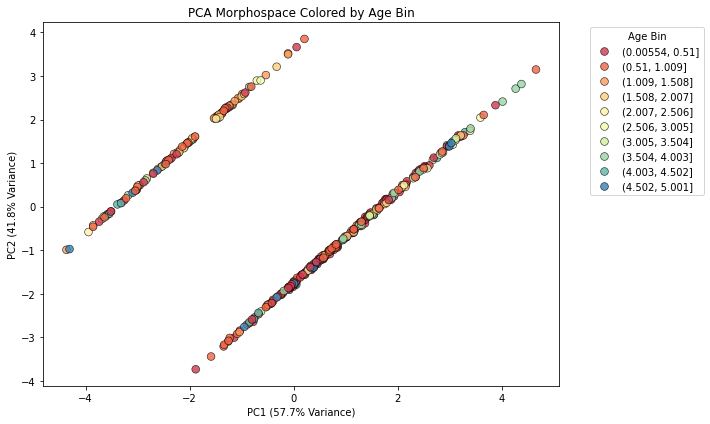

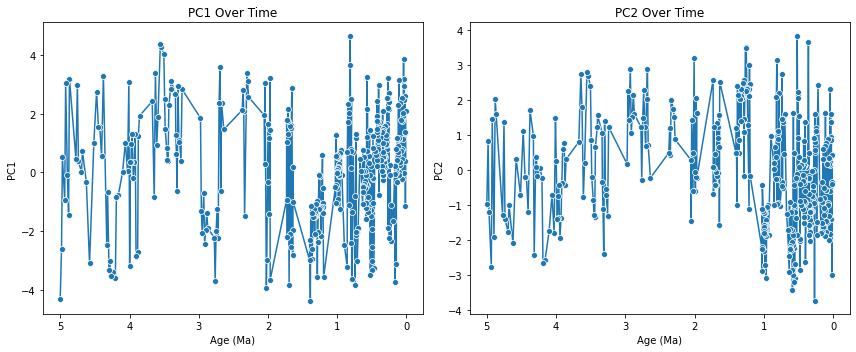

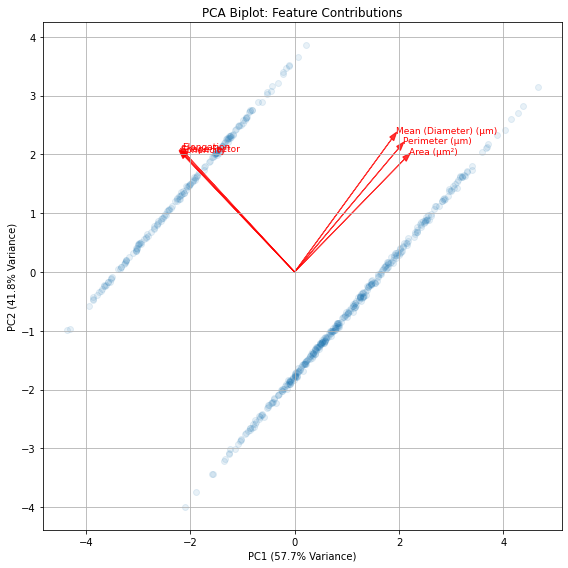

In [112]:
import pandas as pd
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Load data
df = pd.read_csv('analyzer_data.csv')

# Define features and drop missing values
features = ['Mean (Diameter) (µm)', 'Elongation', 'Sphericity', 
            'Shape Factor', 'Area (µm²)', 'Perimeter (µm)']
df_clean = df.dropna(subset=features + ['Age (Ma)'])

# Standardize features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(df_clean[features])

# Run PCA
pca = PCA(n_components=2)
pca_components = pca.fit_transform(X_scaled)

# Create DataFrame with PCA results
pca_df = pd.DataFrame(pca_components, columns=['PC1', 'PC2'])
pca_df['Age (Ma)'] = df_clean['Age (Ma)']
pca_df['Age Bin'] = pd.cut(pca_df['Age (Ma)'], bins=10)
explained = pca.explained_variance_ratio_

# === Plot 1: PCA Scatter Colored by Age Bin ===
plt.figure(figsize=(10, 6))
sns.scatterplot(data=pca_df, x='PC1', y='PC2', hue='Age Bin', palette='Spectral', s=60, edgecolor='k', alpha=0.8)
plt.title('PCA Morphospace Colored by Age Bin')
plt.xlabel(f'PC1 ({explained[0]*100:.1f}% Variance)')
plt.ylabel(f'PC2 ({explained[1]*100:.1f}% Variance)')
plt.legend(title='Age Bin', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

# === Plot 2: PC1 and PC2 vs. Time ===
# Group by Age (rounded for smoothing or binning)
pca_time = pca_df.groupby('Age (Ma)')[['PC1', 'PC2']].mean().reset_index().sort_values('Age (Ma)')

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
sns.lineplot(data=pca_time, x='Age (Ma)', y='PC1', marker='o')
plt.title('PC1 Over Time')
plt.gca().invert_xaxis()  # Age runs backward (older on left)
plt.ylabel('PC1')
plt.xlabel('Age (Ma)')

plt.subplot(1, 2, 2)
sns.lineplot(data=pca_time, x='Age (Ma)', y='PC2', marker='o')
plt.title('PC2 Over Time')
plt.gca().invert_xaxis()
plt.ylabel('PC2')
plt.xlabel('Age (Ma)')

plt.tight_layout()
plt.show()

# === Plot 3: PCA Biplot Showing Feature Contributions ===
components = pca.components_
plt.figure(figsize=(8, 8))
plt.scatter(pca_df['PC1'], pca_df['PC2'], alpha=0.1)

for i, feature in enumerate(features):
    plt.arrow(0, 0, components[0, i]*5, components[1, i]*5, 
              color='red', alpha=0.8, head_width=0.1)
    plt.text(components[0, i]*5.2, components[1, i]*5.2, feature, color='red', fontsize=9)

plt.title('PCA Biplot: Feature Contributions')
plt.xlabel(f'PC1 ({explained[0]*100:.1f}% Variance)')
plt.ylabel(f'PC2 ({explained[1]*100:.1f}% Variance)')
plt.grid()
plt.tight_layout()
plt.show()


/var/folders/jt/0lv95mcn7f784lx7z_pw70tc0000gn/T/ipykernel_9151/4018518877.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(x=pd.cut(merged_data["Age (Ma)"], bins=10), y=merged_data["Mean (Diameter) (µm)"], inner="quartile", palette="coolwarm")


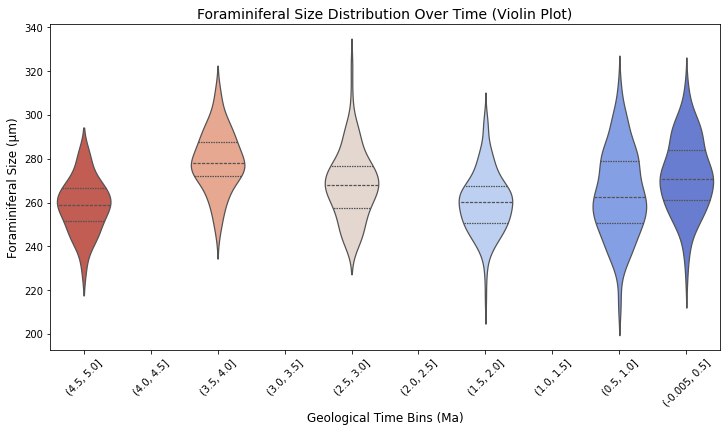

In [68]:
plt.figure(figsize=(12, 6))
sns.violinplot(x=pd.cut(merged_data["Age (Ma)"], bins=10), y=merged_data["Mean (Diameter) (µm)"], inner="quartile", palette="coolwarm")
plt.xticks(rotation=45)
plt.xlabel("Geological Time Bins (Ma)", fontsize=12)
plt.ylabel("Foraminiferal Size (µm)", fontsize=12)
plt.title("Foraminiferal Size Distribution Over Time (Violin Plot)", fontsize=14)
plt.gca().invert_xaxis()
plt.show()


In [ ]:
pip install joypy

In [69]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import joypy
import matplotlib.cm as cm

# Load datasets
foram_data = pd.read_csv("analyzer_data.csv")  # Contains foram size & age info
co2_data = pd.read_csv("co2_annmean_mlo.csv", comment="#")

# Make sure both have a 'year' column (clean headers)
foram_data.columns = [col.strip().lower() for col in foram_data.columns]
co2_data.columns = [col.strip().lower() for col in co2_data.columns]

# Rename column if necessary (adjust based on your actual column names)
co2_data.rename(columns={"year": "year", "mean": "co2_mean"}, inplace=True)
foram_data.rename(columns={"age (ma)": "age_ma", "mean (diameter) (µm)": "mean_diameter_um"}, inplace=True)

# Merge on year if both datasets have it
# (you may skip this merge if CO2 isn't used in this plot)
if "year" in foram_data.columns and "year" in co2_data.columns:
    merged_data = pd.merge(foram_data, co2_data, on="year", how="inner")
else:
    merged_data = foram_data.copy()

# Convert age to numeric and sort from oldest to youngest
merged_data["age_ma"] = pd.to_numeric(merged_data["age_ma"], errors="coerce")
merged_data = merged_data.dropna(subset=["age_ma", "mean_diameter_um"])
merged_data = merged_data.sort_values("age_ma")


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/pandas/core/groupby/ops.py:919: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  res = f(group)
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/pandas/core/groupby/ops.py:919: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  res = f(group)


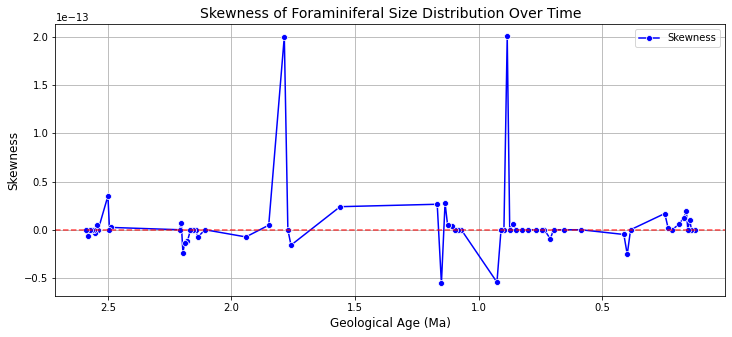

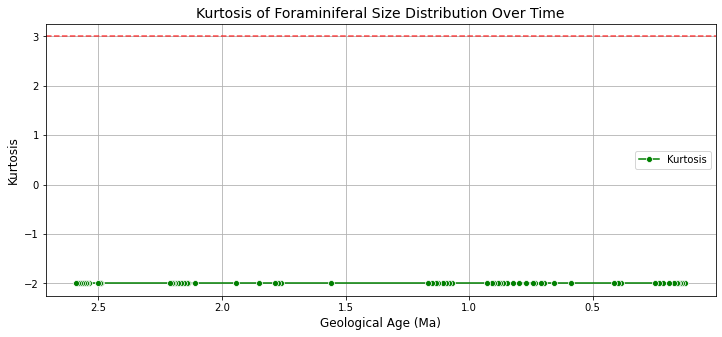

In [70]:
from scipy.stats import kurtosis, skew
import seaborn as sns
import matplotlib.pyplot as plt

# Compute skewness and kurtosis grouped by age
skew_data = merged_data.groupby("age_ma")["mean_diameter_um"].apply(skew).reset_index(name="skewness")
kurtosis_data = merged_data.groupby("age_ma")["mean_diameter_um"].apply(kurtosis).reset_index(name="kurtosis")

# Plot skewness
plt.figure(figsize=(12, 5))
sns.lineplot(x="age_ma", y="skewness", data=skew_data, marker="o", label="Skewness", color="blue")
plt.axhline(0, linestyle="--", color="red", alpha=0.7)
plt.xlabel("Geological Age (Ma)", fontsize=12)
plt.ylabel("Skewness", fontsize=12)
plt.title("Skewness of Foraminiferal Size Distribution Over Time", fontsize=14)
plt.gca().invert_xaxis()  # so time flows correctly
plt.grid(True)
plt.show()

# Plot kurtosis
plt.figure(figsize=(12, 5))
sns.lineplot(x="age_ma", y="kurtosis", data=kurtosis_data, marker="o", label="Kurtosis", color="green")
plt.axhline(3, linestyle="--", color="red", alpha=0.7)  # normal distribution reference
plt.xlabel("Geological Age (Ma)", fontsize=12)
plt.ylabel("Kurtosis", fontsize=12)
plt.title("Kurtosis of Foraminiferal Size Distribution Over Time", fontsize=14)
plt.gca().invert_xaxis()
plt.grid(True)
plt.show()


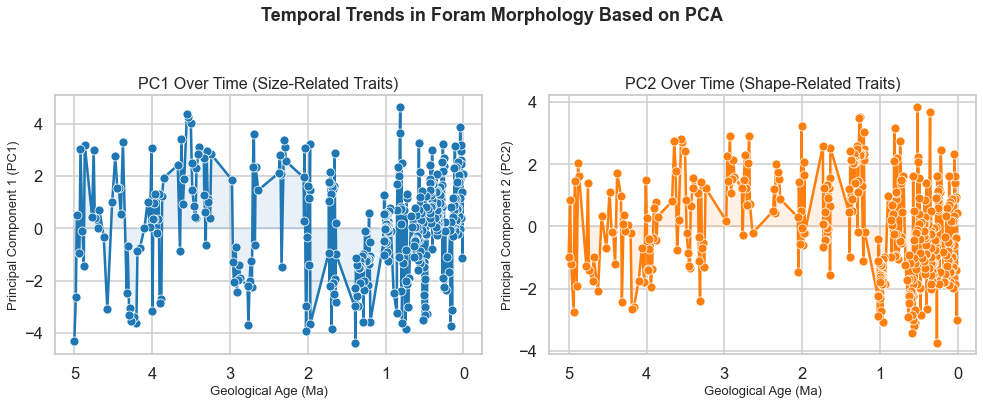

In [113]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set Seaborn theme for presentation style
sns.set(style="whitegrid", context="talk")

# Sort and prepare time data
pca_time = pca_df.groupby('Age (Ma)')[['PC1', 'PC2']].mean().reset_index().sort_values('Age (Ma)')

# Create figure
plt.figure(figsize=(14, 6))

# PC1 subplot
plt.subplot(1, 2, 1)
sns.lineplot(data=pca_time, x='Age (Ma)', y='PC1', marker='o', linewidth=2.5, color='#1f77b4')
plt.fill_between(pca_time['Age (Ma)'], pca_time['PC1'], alpha=0.1, color='#1f77b4')  # Light fill
plt.gca().invert_xaxis()  # Age goes from old to recent
plt.title('PC1 Over Time (Size-Related Traits)', fontsize=16)
plt.xlabel('Geological Age (Ma)', fontsize=13)
plt.ylabel('Principal Component 1 (PC1)', fontsize=13)

# PC2 subplot
plt.subplot(1, 2, 2)
sns.lineplot(data=pca_time, x='Age (Ma)', y='PC2', marker='o', linewidth=2.5, color='#ff7f0e')
plt.fill_between(pca_time['Age (Ma)'], pca_time['PC2'], alpha=0.1, color='#ff7f0e')
plt.gca().invert_xaxis()
plt.title('PC2 Over Time (Shape-Related Traits)', fontsize=16)
plt.xlabel('Geological Age (Ma)', fontsize=13)
plt.ylabel('Principal Component 2 (PC2)', fontsize=13)

# Layout and styling
plt.suptitle('Temporal Trends in Foram Morphology Based on PCA', fontsize=18, weight='bold')
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()


In [71]:
print(merged_data.columns.tolist())


['min (diameter) (µm)', 'max (diameter) (µm)', 'mean_diameter_um', 'elongation', 'sphericity', 'shape factor', 'mean (gray intensity value)', 'age_ma', 'file_name', 'area (µm²)', 'perimeter (µm)']


KeyError: 'CO2_ppm'

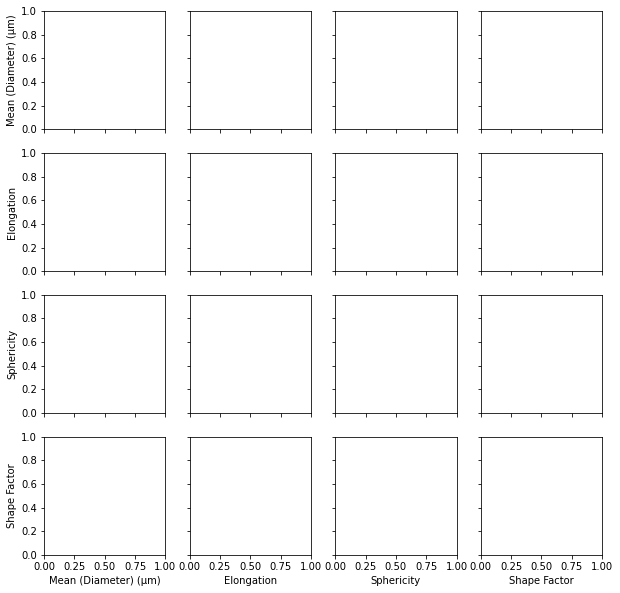

In [72]:
import seaborn as sns
sns.pairplot(merged_data, hue="CO2_ppm", vars=["Mean (Diameter) (µm)", "Elongation", "Sphericity", "Shape Factor"], height=2.5)
plt.suptitle("Feature Relationships with CO₂ Levels", fontsize=14)
plt.show()


In [ ]:
pip install corr_matrix

In [73]:
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import pearsonr

def correlation_circle(corr_matrix):
    fig, ax = plt.subplots(figsize=(8, 8))
    ax.set_xlim(-1, 1)
    ax.set_ylim(-1, 1)
    
    # Create circular correlation plot
    for i in range(len(corr_matrix.columns)):
        for j in range(i + 1, len(corr_matrix.columns)):
            ax.plot([0, corr_matrix.iloc[i, j]], [0, corr_matrix.iloc[j, i]], marker='o', linestyle='-', color='b', alpha=0.7)
    
    ax.set_title("Correlation Circle", fontsize=14)
    plt.show()

correlation_circle(corr_matrix)


NameError: name 'corr_matrix' is not defined

KeyError: 'Mean (Diameter) (µm)'

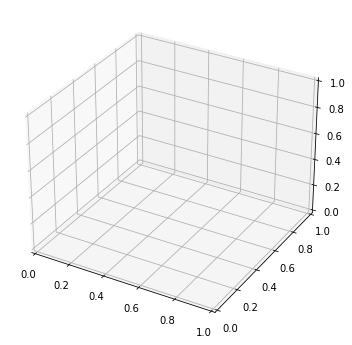

In [74]:
from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(111, projection='3d')

x = merged_data["Mean (Diameter) (µm)"]
y = merged_data["Elongation"]
z = merged_data["CO2_ppm"]

ax.scatter(x, y, z, c=z, cmap='coolwarm')
ax.set_xlabel("Mean (Diameter) (µm)")
ax.set_ylabel("Elongation")
ax.set_zlabel("CO2_ppm")
ax.set_title("3D Scatter Plot of Features vs CO₂ Levels", fontsize=14)
plt.show()


In [75]:
plt.figure(figsize=(10, 6))
sns.heatmap(corr_matrix, annot=True, cmap="coolwarm", fmt=".2f", linewidths=0.5, cbar_kws={'label': 'Correlation Value'})
plt.title("Correlation Between Features and CO₂ Levels", fontsize=16)
plt.xticks(rotation=45)
plt.yticks(rotation=45)
plt.show()


NameError: name 'corr_matrix' is not defined

<Figure size 720x432 with 0 Axes>

In [76]:
plt.figure(figsize=(10, 6))
sns.scatterplot(data=merged_data, x="Mean (Diameter) (µm)", y="Elongation", size="CO2_ppm", hue="Sphericity", palette="coolwarm", sizes=(20, 200), legend=False)
plt.title("Bubble Chart: Features vs CO₂ Levels", fontsize=14)
plt.show()


ValueError: Could not interpret value `Mean (Diameter) (µm)` for `x`. An entry with this name does not appear in `data`.

<Figure size 720x432 with 0 Axes>

In [77]:
from scipy.stats import skew, kurtosis

# Compute skewness & kurtosis over time
skewness_data = merged_data.groupby("Age (Ma)")["Mean (Diameter) (µm)"].apply(skew).reset_index()
kurtosis_data = merged_data.groupby("Age (Ma)")["Mean (Diameter) (µm)"].apply(kurtosis).reset_index()

# Plot
fig, ax1 = plt.subplots(figsize=(12, 6))
ax2 = ax1.twinx()

sns.lineplot(data=skewness_data, x="Age (Ma)", y="Mean (Diameter) (µm)", ax=ax1, color="blue", marker="o", label="Skewness")
sns.lineplot(data=kurtosis_data, x="Age (Ma)", y="Mean (Diameter) (µm)", ax=ax2, color="red", marker="s", linestyle="dashed", label="Kurtosis")

ax1.set_xlabel("Geological Age (Ma)", fontsize=12)
ax1.set_ylabel("Skewness", color="blue", fontsize=12)
ax2.set_ylabel("Kurtosis", color="red", fontsize=12)
plt.title("Skewness & Kurtosis of Foram Size Distribution Over Time", fontsize=14)
plt.gca().invert_xaxis()
plt.show()


KeyError: 'Age (Ma)'

In [78]:
import ruptures as rpt

# Extract size time-series
signal = merged_data.groupby("Age (Ma)")["Mean (Diameter) (µm)"].mean().dropna().values

# Apply change point detection
algo = rpt.Pelt(model="rbf").fit(signal)
change_points = algo.predict(pen=5)

# Ensure valid indices
valid_change_points = [cp for cp in change_points if cp < len(signal)]

# Plot results
plt.figure(figsize=(12, 6))
plt.plot(merged_data["Age (Ma)"], merged_data["Mean (Diameter) (µm)"], label="Foraminiferal Size", color="blue")
for cp in valid_change_points:
    plt.axvline(x=merged_data["Age (Ma)"].iloc[cp], color='red', linestyle='dashed', label="Change Point")

plt.xlabel("Age (Ma)", fontsize=12)
plt.ylabel("Mean Diameter (µm)", fontsize=12)
plt.title("Change Point Detection in Foram Size Evolution", fontsize=14)
plt.gca().invert_xaxis()
plt.legend()
plt.show()


KeyError: 'Age (Ma)'

In [79]:
plt.figure(figsize=(12, 6))
ax1 = sns.lineplot(data=merged_data, x="Age (Ma)", y="Mean (Diameter) (µm)", color="blue", label="Foraminiferal Size")
ax2 = plt.twinx()
sns.lineplot(data=merged_data, x="Age (Ma)", y="CO2_ppm", ax=ax2, color="red", linestyle="dashed", label="CO₂ Levels")

ax1.set_xlabel("Geological Age (Ma)", fontsize=12)
ax1.set_ylabel("Mean Foram Size (µm)", color="blue", fontsize=12)
ax2.set_ylabel("CO₂ Levels (ppm)", color="red", fontsize=12)
plt.title("Foraminiferal Size Evolution vs. CO₂ Levels Over Time", fontsize=14)
plt.gca().invert_xaxis()
plt.show()


ValueError: Could not interpret value `Age (Ma)` for `x`. An entry with this name does not appear in `data`.

<Figure size 864x432 with 0 Axes>

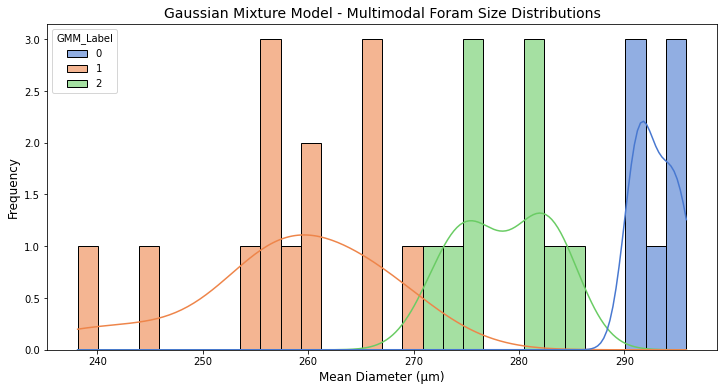

In [80]:
from sklearn.mixture import GaussianMixture
import numpy as np

# Prepare data for GMM
foram_sizes = data["Mean (Diameter) (µm)"].dropna().values.reshape(-1, 1)

# Fit GMM model with 3 clusters
gmm = GaussianMixture(n_components=3, random_state=42)
gmm.fit(foram_sizes)
data["GMM_Label"] = gmm.predict(foram_sizes)

# Plot GMM clusters
plt.figure(figsize=(12, 6))
sns.histplot(data=data, x="Mean (Diameter) (µm)", hue="GMM_Label", bins=30, kde=True, alpha=0.6, palette="muted")

plt.title("Gaussian Mixture Model - Multimodal Foram Size Distributions", fontsize=14)
plt.xlabel("Mean Diameter (µm)", fontsize=12)
plt.ylabel("Frequency", fontsize=12)
plt.show()


/var/folders/jt/0lv95mcn7f784lx7z_pw70tc0000gn/T/ipykernel_9151/1975572848.py:4: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  signal = data["Mean (Diameter) (µm)"].fillna(method="bfill").fillna(method="ffill").values


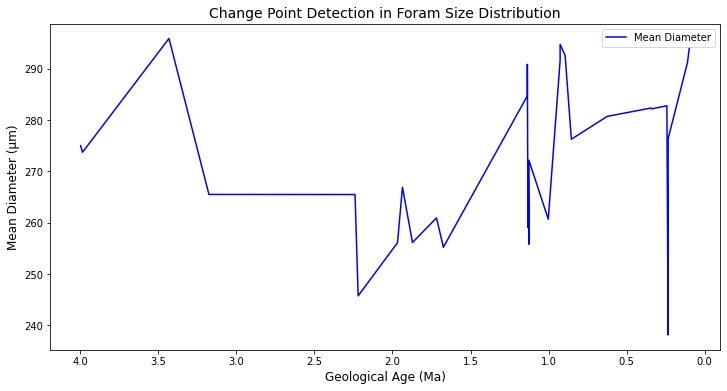

In [81]:
import ruptures as rpt

# Extract size data and apply forward/backward fill for missing values
signal = data["Mean (Diameter) (µm)"].fillna(method="bfill").fillna(method="ffill").values

# Apply Change Point Detection
algo = rpt.Pelt(model="rbf").fit(signal)
change_points = algo.predict(pen=5)

# Ensure Change Points Are Within Valid Index Range
valid_change_points = [cp for cp in change_points if cp < len(data)]

# Plot results
plt.figure(figsize=(12, 6))
plt.plot(data["Age (Ma)"], data["Mean (Diameter) (µm)"], label="Mean Diameter", color="blue")

for cp in valid_change_points:
    plt.axvline(x=data["Age (Ma)"].iloc[cp], color="red", linestyle="dashed", label="Change Point")

plt.title("Change Point Detection in Foram Size Distribution", fontsize=14)
plt.xlabel("Geological Age (Ma)", fontsize=12)
plt.ylabel("Mean Diameter (µm)", fontsize=12)
plt.legend()
plt.gca().invert_xaxis()
plt.show()


KeyError: 'Elongation'

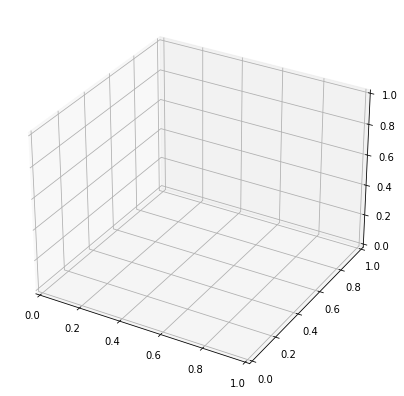

In [82]:
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection="3d")

ax.scatter(data["Age (Ma)"], data["Elongation"], data["Mean (Diameter) (µm)"], c=data["Sphericity"], cmap="viridis", alpha=0.7)

ax.set_xlabel("Age (Ma)")
ax.set_ylabel("Elongation")
ax.set_zlabel("Mean Diameter (µm)")
ax.set_title("3D Scatter Plot: Foram Size vs. Morphometric Evolution")
plt.show()


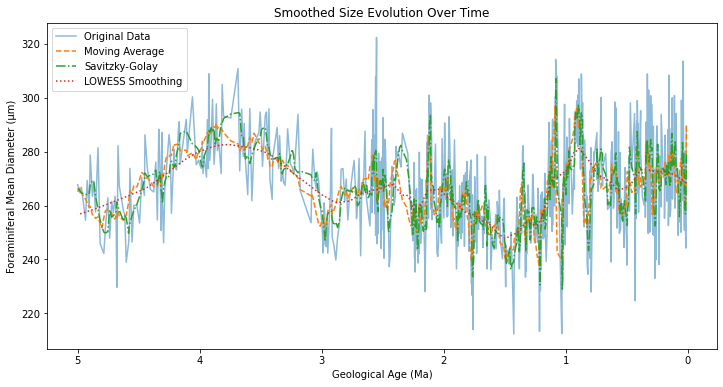

In [83]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
from scipy.signal import savgol_filter

# Load your dataset
data = pd.read_csv("analyzer_data.csv")  # Replace with your actual file

# Sort by Age
data = data.sort_values(by="Age (Ma)").reset_index(drop=True)

# Apply a moving average (window=10)
data["Smoothed_Size_MA"] = data["Mean (Diameter) (µm)"].rolling(window=10, min_periods=1).mean()

# Apply Savitzky-Golay smoothing (window=11, polynomial order=3)
data["Smoothed_Size_SG"] = savgol_filter(data["Mean (Diameter) (µm)"], window_length=11, polyorder=3)

# Apply LOWESS smoothing
lowess = sm.nonparametric.lowess(data["Mean (Diameter) (µm)"], data["Age (Ma)"], frac=0.1)
data["Smoothed_Size_LOWESS"] = lowess[:, 1]

# Plot the results
plt.figure(figsize=(12, 6))
plt.plot(data["Age (Ma)"], data["Mean (Diameter) (µm)"], label="Original Data", alpha=0.5)
plt.plot(data["Age (Ma)"], data["Smoothed_Size_MA"], label="Moving Average", linestyle="--")
plt.plot(data["Age (Ma)"], data["Smoothed_Size_SG"], label="Savitzky-Golay", linestyle="-.")
plt.plot(data["Age (Ma)"], data["Smoothed_Size_LOWESS"], label="LOWESS Smoothing", linestyle="dotted")
plt.xlabel("Geological Age (Ma)")
plt.ylabel("Foraminiferal Mean Diameter (µm)")
plt.title("Smoothed Size Evolution Over Time")
plt.legend()
plt.gca().invert_xaxis()  # Geological time runs backward
plt.show()


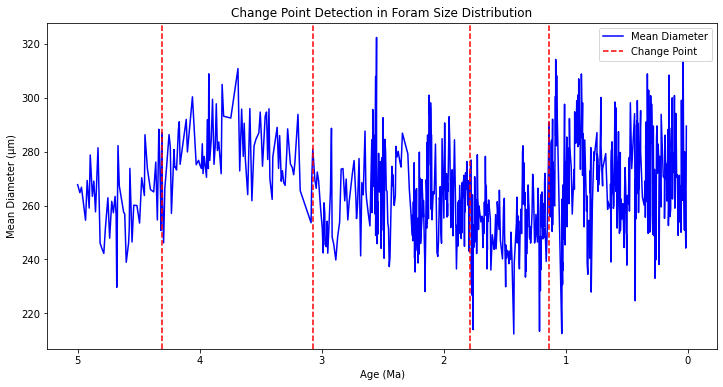

In [84]:
import numpy as np
import ruptures as rpt

# Convert to numpy array
size_signal = data["Mean (Diameter) (µm)"].values

# Apply change point detection using Pelt model
algo = rpt.Pelt(model="rbf").fit(size_signal)
change_points = algo.predict(pen=10)  # Experiment with penalty value

# Plot change points
plt.figure(figsize=(12, 6))
plt.plot(data["Age (Ma)"], size_signal, label="Mean Diameter", color="blue")
for cp in change_points[:-1]:  # Exclude the last CP (end of data)
    plt.axvline(x=data["Age (Ma)"].iloc[cp], color='red', linestyle="dashed", label="Change Point" if cp == change_points[0] else "")
plt.xlabel("Age (Ma)")
plt.ylabel("Mean Diameter (µm)")
plt.title("Change Point Detection in Foram Size Distribution")
plt.legend()
plt.gca().invert_xaxis()  # Geological time runs backward
plt.show()

2025-04-30 19:39:09.640094: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


Epoch 1/50
42/42 [==============================] - 3s 22ms/step - loss: 0.0865 - val_loss: 0.0179
Epoch 2/50
42/42 [==============================] - 0s 10ms/step - loss: 0.0214 - val_loss: 0.0135
Epoch 3/50
42/42 [==============================] - 0s 12ms/step - loss: 0.0211 - val_loss: 0.0137
Epoch 4/50
42/42 [==============================] - 0s 10ms/step - loss: 0.0213 - val_loss: 0.0131
Epoch 5/50
42/42 [==============================] - 1s 14ms/step - loss: 0.0206 - val_loss: 0.0153
Epoch 6/50
42/42 [==============================] - 1s 12ms/step - loss: 0.0202 - val_loss: 0.0137
Epoch 7/50
42/42 [==============================] - 0s 10ms/step - loss: 0.0204 - val_loss: 0.0130
Epoch 8/50
42/42 [==============================] - 0s 10ms/step - loss: 0.0202 - val_loss: 0.0154
Epoch 9/50
42/42 [==============================] - 0s 10ms/step - loss: 0.0199 - val_loss: 0.0131
Epoch 10/50
42/42 [==============================] - 0s 10ms/step - loss: 0.0198 - val_loss: 0.0151
Epoch 11/

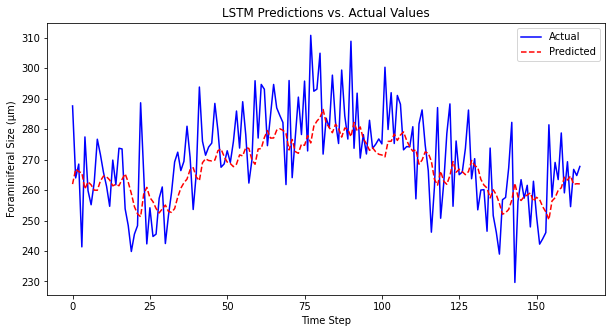

In [85]:
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

# Normalize data
scaler = MinMaxScaler()
data_scaled = scaler.fit_transform(data[["Mean (Diameter) (µm)"]])

# Create sequences for LSTM
def create_sequences(data, time_steps=10):
    X, y = [], []
    for i in range(len(data) - time_steps):
        X.append(data[i:i+time_steps])
        y.append(data[i+time_steps, 0])  # Predict size
    return np.array(X), np.array(y)

time_steps = 10
X, y = create_sequences(data_scaled, time_steps)

# Train-test split
split = int(0.8 * len(X))
X_train, X_test = X[:split], X[split:]
y_train, y_test = y[:split], y[split:]

# Build LSTM Model
model = Sequential([
    LSTM(50, activation='relu', return_sequences=True, input_shape=(time_steps, 1)),
    LSTM(50, activation='relu'),
    Dense(1)
])

# Compile Model
model.compile(optimizer='adam', loss='mse')

# Train Model
model.fit(X_train, y_train, epochs=50, batch_size=16, validation_data=(X_test, y_test), verbose=1)

# Predict on test set
y_pred = model.predict(X_test)

# Inverse transform predictions
y_pred_original = scaler.inverse_transform(y_pred)
y_test_original = scaler.inverse_transform(y_test.reshape(-1, 1))

# Plot predictions vs actual values
plt.figure(figsize=(10, 5))
plt.plot(y_test_original, label="Actual", color="blue")
plt.plot(y_pred_original, label="Predicted", color="red", linestyle="dashed")
plt.xlabel("Time Step")
plt.ylabel("Foraminiferal Size (µm)")
plt.legend()
plt.title("LSTM Predictions vs. Actual Values")
plt.show()


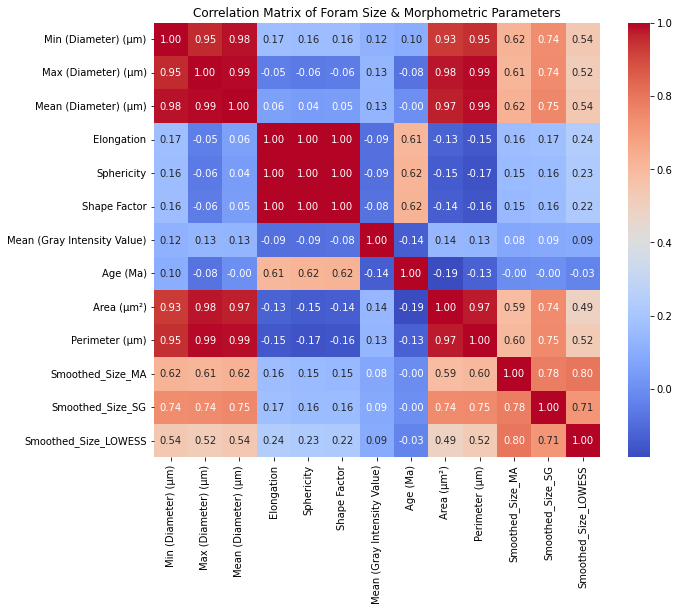

In [86]:
import seaborn as sns
import matplotlib.pyplot as plt

# Select only numeric columns
numeric_data = data.select_dtypes(include=['number'])

# Compute correlation
corr_matrix = numeric_data.corr()

# Plot
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Correlation Matrix of Foram Size & Morphometric Parameters")
plt.show()


/var/folders/jt/0lv95mcn7f784lx7z_pw70tc0000gn/T/ipykernel_9151/2429522625.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x=pd.cut(data["Age (Ma)"], bins=5), y=data["Mean (Diameter) (µm)"], palette="coolwarm")


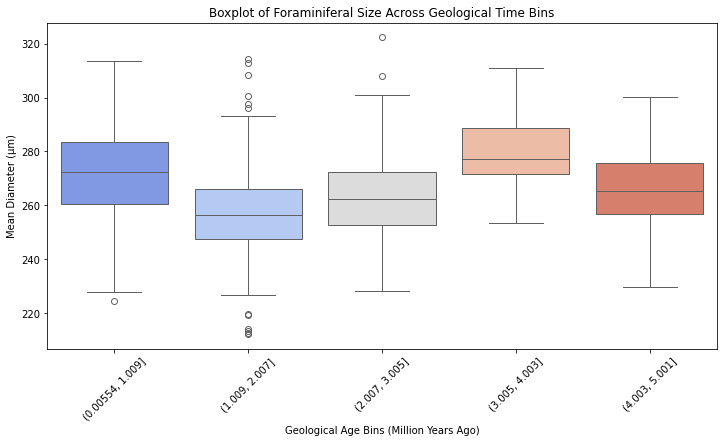

In [87]:
plt.figure(figsize=(12, 6))
sns.boxplot(x=pd.cut(data["Age (Ma)"], bins=5), y=data["Mean (Diameter) (µm)"], palette="coolwarm")
plt.xticks(rotation=45)
plt.title("Boxplot of Foraminiferal Size Across Geological Time Bins")
plt.xlabel("Geological Age Bins (Million Years Ago)")
plt.ylabel("Mean Diameter (µm)")
plt.show()


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


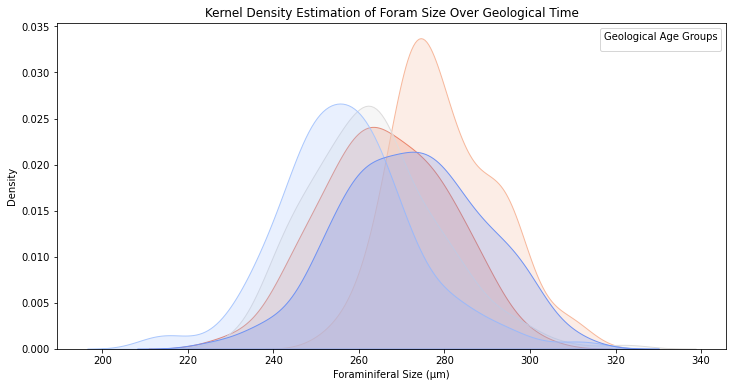

In [88]:
plt.figure(figsize=(12, 6))
sns.kdeplot(data=data, x="Mean (Diameter) (µm)", hue=pd.cut(data["Age (Ma)"], bins=5), fill=True, common_norm=False, palette="coolwarm")
plt.xlabel("Foraminiferal Size (µm)")
plt.ylabel("Density")
plt.title("Kernel Density Estimation of Foram Size Over Geological Time")
plt.legend(title="Geological Age Groups")
plt.show()


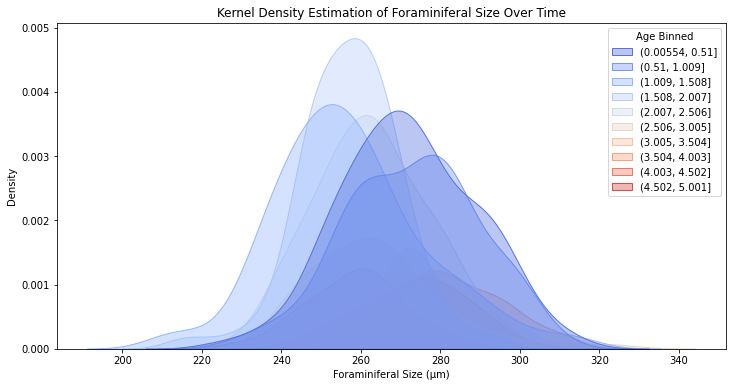

Time Interval (0.00554, 0.51] → (0.51, 1.009]
  KL Divergence: 0.335
  Wasserstein Distance: 1.637
  Jensen-Shannon Divergence: 0.192
--------------------------------------------------
Time Interval (0.51, 1.009] → (1.009, 1.508]
  KL Divergence: 0.642
  Wasserstein Distance: 15.931
  Jensen-Shannon Divergence: 0.349
--------------------------------------------------
Time Interval (1.009, 1.508] → (1.508, 2.007]
  KL Divergence: 0.792
  Wasserstein Distance: 5.448
  Jensen-Shannon Divergence: 0.245
--------------------------------------------------
Time Interval (1.508, 2.007] → (2.007, 2.506]
  KL Divergence: 0.445
  Wasserstein Distance: 5.930
  Jensen-Shannon Divergence: 0.212
--------------------------------------------------
Time Interval (2.007, 2.506] → (2.506, 3.005]
  KL Divergence: 1.210
  Wasserstein Distance: 2.046
  Jensen-Shannon Divergence: 0.234
--------------------------------------------------
Time Interval (2.506, 3.005] → (3.005, 3.504]
  KL Divergence: 4.826
  Wass

In [89]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import entropy, wasserstein_distance
from scipy.spatial.distance import jensenshannon

# Load Data
data = pd.read_csv("analyzer_data.csv")

# Standardize column names
data.columns = data.columns.str.strip()

# Extract required columns
age_column = "Age (Ma)"
size_column = "Mean (Diameter) (µm)"

# Drop NaN values
data = data.dropna(subset=[size_column, age_column])

# Bin data into time intervals
num_bins = 10  # Define number of time bins
data["Age Binned"] = pd.cut(data[age_column], bins=num_bins)

# KDE Visualization
plt.figure(figsize=(12, 6))
sns.kdeplot(data=data, x=size_column, hue="Age Binned", fill=True, alpha=0.4, palette="coolwarm")
plt.title("Kernel Density Estimation of Foraminiferal Size Over Time")
plt.xlabel("Foraminiferal Size (µm)")
plt.ylabel("Density")
plt.show()

# Compute Divergence Metrics
time_bins = sorted(data["Age Binned"].dropna().unique())  # Sorted bin intervals
num_hist_bins = 20  # Fixed number of bins for histograms

for i in range(len(time_bins) - 1):
    size_t1 = data[data["Age Binned"] == time_bins[i]][size_column]
    size_t2 = data[data["Age Binned"] == time_bins[i + 1]][size_column]

    # Convert to histograms with fixed binning
    hist_t1, bin_edges = np.histogram(size_t1, bins=num_hist_bins, density=True)
    hist_t2, _ = np.histogram(size_t2, bins=bin_edges, density=True)  # Use same bins

    # Smooth histograms to avoid zero probabilities
    hist_t1 += 1e-9
    hist_t2 += 1e-9

    # Normalize to probability distributions
    hist_t1 /= hist_t1.sum()
    hist_t2 /= hist_t2.sum()

    # Calculate Divergence Metrics
    kl_div = entropy(hist_t1, hist_t2)  # KL Divergence
    wasserstein_dist = wasserstein_distance(size_t1, size_t2)  # Wasserstein Distance
    js_div = jensenshannon(hist_t1, hist_t2)  # Jensen-Shannon Divergence

    print(f"Time Interval {time_bins[i]} → {time_bins[i+1]}")
    print(f"  KL Divergence: {kl_div:.3f}")
    print(f"  Wasserstein Distance: {wasserstein_dist:.3f}")
    print(f"  Jensen-Shannon Divergence: {js_div:.3f}")
    print("-" * 50)


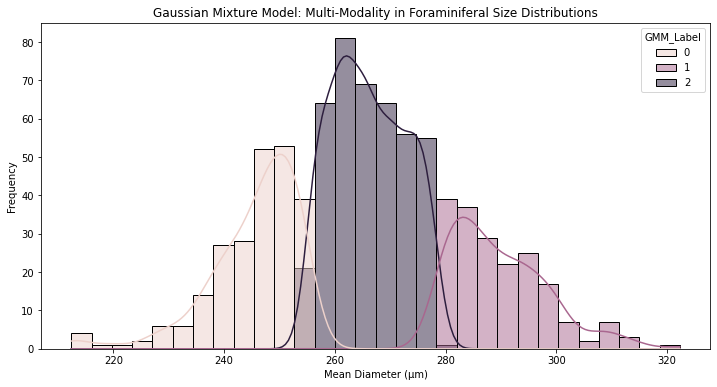

In [90]:
from sklearn.mixture import GaussianMixture

# Fit GMM to detect multimodal distributions
gmm = GaussianMixture(n_components=3, random_state=42)
data["GMM_Label"] = gmm.fit_predict(data[[size_column]])

# Visualizing GMM Components
plt.figure(figsize=(12, 6))
sns.histplot(data=data, x=size_column, hue="GMM_Label", bins=30, kde=True, alpha=0.5)
plt.title("Gaussian Mixture Model: Multi-Modality in Foraminiferal Size Distributions")
plt.xlabel("Mean Diameter (µm)")
plt.ylabel("Frequency")
plt.show()


In [ ]:
import numpy as np
import pandas as pd
from scipy.stats import kurtosis, moment
import seaborn as sns
import matplotlib.pyplot as plt

# Compute statistical moments
data['5th Moment'] = data.groupby('Age Binned')["Mean (Diameter) (µm)"].transform(lambda x: moment(x, moment=5))
data['6th Moment'] = data.groupby('Age Binned')["Mean (Diameter) (µm)"].transform(lambda x: moment(x, moment=6))
data['Kurtosis'] = data.groupby('Age Binned')["Mean (Diameter) (µm)"].transform(lambda x: kurtosis(x))

# Line plot for moments
plt.figure(figsize=(12, 6))
sns.lineplot(data=data, x="Age (Ma)", y="Kurtosis", marker="o", color="red", label="Kurtosis")
sns.lineplot(data=data, x="Age (Ma)", y="5th Moment", marker="s", color="blue", label="5th Moment")
sns.lineplot(data=data, x="Age (Ma)", y="6th Moment", marker="^", color="green", label="6th Moment")

plt.xlabel("Geological Age (Ma)", fontsize=12)
plt.ylabel("Moment Values", fontsize=12)
plt.title("Evolution of Kurtosis and Higher-Order Moments Over Time", fontsize=14)
plt.legend()
plt.show()


/var/folders/jt/0lv95mcn7f784lx7z_pw70tc0000gn/T/ipykernel_9151/3810575118.py:17: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=df_wasserstein, x="Age Bins", y="Wasserstein Distance", palette="coolwarm")


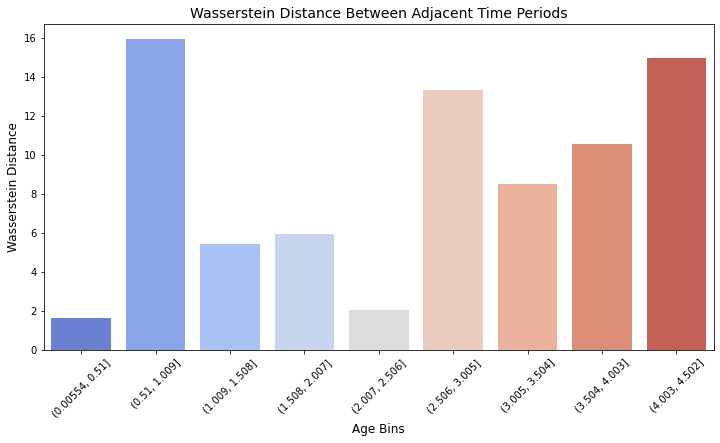

In [91]:
from scipy.stats import wasserstein_distance

time_bins = sorted(data["Age Binned"].unique())
distances = []

for i in range(len(time_bins) - 1):
    t1 = data[data["Age Binned"] == time_bins[i]]["Mean (Diameter) (µm)"]
    t2 = data[data["Age Binned"] == time_bins[i+1]]["Mean (Diameter) (µm)"]
    distance = wasserstein_distance(t1, t2)
    distances.append(distance)

# Convert to DataFrame
df_wasserstein = pd.DataFrame({"Age Bins": time_bins[:-1], "Wasserstein Distance": distances})

# Plot
plt.figure(figsize=(12, 6))
sns.barplot(data=df_wasserstein, x="Age Bins", y="Wasserstein Distance", palette="coolwarm")
plt.xlabel("Age Bins", fontsize=12)
plt.ylabel("Wasserstein Distance", fontsize=12)
plt.title("Wasserstein Distance Between Adjacent Time Periods", fontsize=14)
plt.xticks(rotation=45)
plt.show()


In [ ]:
from scipy.stats import wasserstein_distance

# Compute Wasserstein Distance across adjacent time bins
time_bins = sorted(data["Age Binned"].unique())

for i in range(len(time_bins) - 1):
    t1 = data[data["Age Binned"] == time_bins[i]]["Mean (Diameter) (µm)"]
    t2 = data[data["Age Binned"] == time_bins[i+1]]["Mean (Diameter) (µm)"]

    distance = wasserstein_distance(t1, t2)
    print(f"Wasserstein Distance (T{i} → T{i+1}): {distance:.3f}")


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


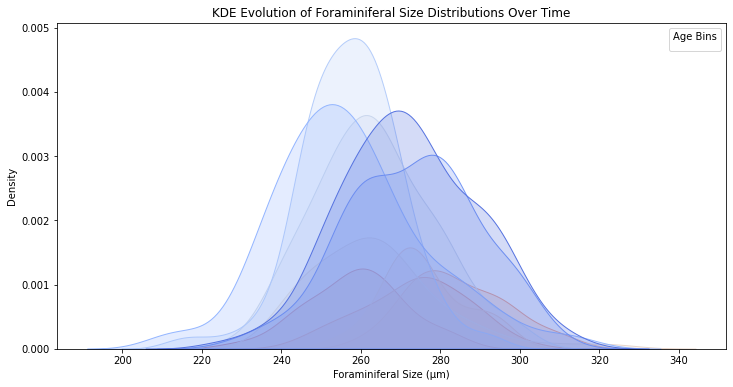

In [92]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
sns.kdeplot(data=data, x="Mean (Diameter) (µm)", hue="Age Binned", fill=True, palette="coolwarm")
plt.xlabel("Foraminiferal Size (µm)")
plt.ylabel("Density")
plt.title("KDE Evolution of Foraminiferal Size Distributions Over Time")
plt.legend(title="Age Bins")
plt.show()


In [ ]:
from scipy.spatial.distance import directed_hausdorff

distances = []
for i in range(len(time_bins) - 1):
    t1 = data[data["Age Binned"] == time_bins[i]][["Mean (Diameter) (µm)", "Age (Ma)"]].values
    t2 = data[data["Age Binned"] == time_bins[i+1]][["Mean (Diameter) (µm)", "Age (Ma)"]].values

    dist = directed_hausdorff(t1, t2)[0]
    distances.append(dist)


In [ ]:
from sklearn.mixture import GaussianMixture

# Fit GMM model
gmm = GaussianMixture(n_components=3, random_state=42)
data["GMM Cluster"] = gmm.fit_predict(data[["Mean (Diameter) (µm)"]])

# Visualization
plt.figure(figsize=(12, 6))
sns.histplot(data=data, x="Mean (Diameter) (µm)", hue="GMM Cluster", bins=30, kde=True, alpha=0.6)
plt.xlabel("Foraminiferal Size (µm)", fontsize=12)
plt.ylabel("Frequency", fontsize=12)
plt.title("Gaussian Mixture Model - Morphogroup Identification", fontsize=14)
plt.legend(title="Cluster")
plt.show()


In [ ]:
import ruptures as rpt

signal = data["Mean (Diameter) (µm)"].values
algo = rpt.Pelt(model="rbf").fit(signal)
change_points = algo.predict(pen=5)


/var/folders/jt/0lv95mcn7f784lx7z_pw70tc0000gn/T/ipykernel_9151/2327551541.py:19: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  fractal_dims = data.groupby("Age Binned")["Mean (Diameter) (µm)"].apply(fractal_dimension)


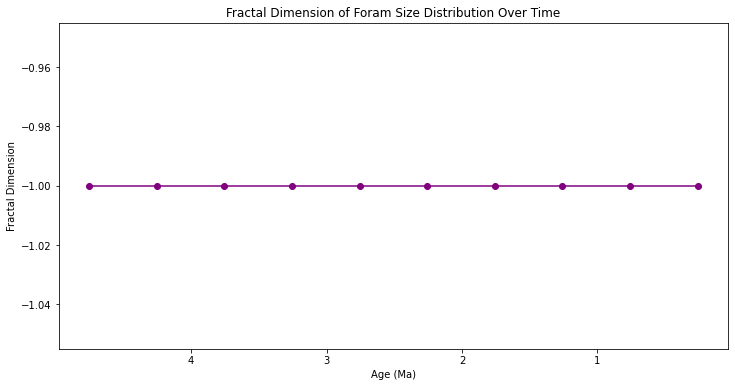

In [93]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import linregress

# Function to calculate fractal dimension
def fractal_dimension(data, scales=[2, 4, 8, 16, 32]):
    counts = []
    for scale in scales:
        count = len(np.histogram(data, bins=scale)[0])
        counts.append(count)
    
    log_counts = np.log(counts)
    log_scales = np.log(scales)
    
    slope, _, _, _, _ = linregress(log_scales, log_counts)
    return -slope  # Fractal dimension

# Apply fractal dimension calculation for different age bins
fractal_dims = data.groupby("Age Binned")["Mean (Diameter) (µm)"].apply(fractal_dimension)

# **Convert Interval Index to Midpoints for Correct Plotting**
fractal_dims.index = [interval.mid for interval in fractal_dims.index]

# Plot results
plt.figure(figsize=(12, 6))
plt.plot(fractal_dims.index, fractal_dims.values, marker="o", linestyle="-", color="purple")
plt.xlabel("Age (Ma)")
plt.ylabel("Fractal Dimension")
plt.title("Fractal Dimension of Foram Size Distribution Over Time")
plt.gca().invert_xaxis()  # Reverse time axis
plt.show()


In [ ]:
pip install ripser

In [ ]:
from ripser import ripser
import persim

# Compute persistence diagram
size_values = data[["Mean (Diameter) (µm)"]].values
dgms = ripser(size_values, maxdim=1)['dgms']

# Plot persistence diagram
plt.figure(figsize=(8, 6))
persim.plot_diagrams(dgms, show=True)
plt.title("Persistent Homology Diagram of Foram Size Distribution")
plt.show()


In [ ]:
pip install hmmlearn

In [ ]:
import numpy as np
from hmmlearn import hmm

# Prepare data
X = data[["Mean (Diameter) (µm)"]].dropna().values.reshape(-1, 1)

# Fit HMM model
model = hmm.GaussianHMM(n_components=3, covariance_type="diag", n_iter=100)
model.fit(X)

# Predict states
data["HMM_State"] = model.predict(X)

# Plot results
plt.figure(figsize=(12, 6))
sns.scatterplot(data=data, x="Age (Ma)", y="Mean (Diameter) (µm)", hue="HMM_State", palette="coolwarm")
plt.xlabel("Age (Ma)")
plt.ylabel("Mean Diameter (µm)")
plt.title("Hidden Markov Model - Evolutionary State Transitions in Foram Sizes")
plt.gca().invert_xaxis()
plt.show()


In [ ]:
pip install minisom

In [ ]:
from minisom import MiniSom

# Prepare data
X = data[["Mean (Diameter) (µm)", "Elongation", "Sphericity"]].dropna().values

# Initialize and train SOM
som = MiniSom(4, 4, X.shape[1], sigma=0.5, learning_rate=0.5)
som.train_random(X, 1000)

# Assign cluster labels
labels = np.array([som.winner(x) for x in X])
data["SOM_Cluster"] = [f"{x[0]}-{x[1]}" for x in labels]

# Plot results
plt.figure(figsize=(12, 6))
sns.scatterplot(data=data, x="Age (Ma)", y="Mean (Diameter) (µm)", hue="SOM_Cluster", palette="viridis")
plt.xlabel("Age (Ma)")
plt.ylabel("Mean Diameter (µm)")
plt.title("Self-Organizing Maps - Foram Morphotype Clustering")
plt.gca().invert_xaxis()
plt.show()


In [ ]:
pip install PyWavelets


In [ ]:
import pywt
import numpy as np

# Prepare data
signal = data["Mean (Diameter) (µm)"].dropna().values

# Perform Wavelet Transform
coeffs, freqs = pywt.cwt(signal, scales=np.arange(1, 50), wavelet='morl')

# Plot results
plt.figure(figsize=(12, 6))
plt.imshow(coeffs, aspect='auto', cmap="coolwarm", extent=[min(data["Age (Ma)"]), max(data["Age (Ma)"]), 1, 50])
plt.colorbar(label="Wavelet Coefficient Magnitude")
plt.xlabel("Age (Ma)")
plt.ylabel("Frequency (Cycles/Ma)")
plt.title("Wavelet Transform - Cyclic Trends in Foram Size Evolution")
plt.gca().invert_xaxis()
plt.show()


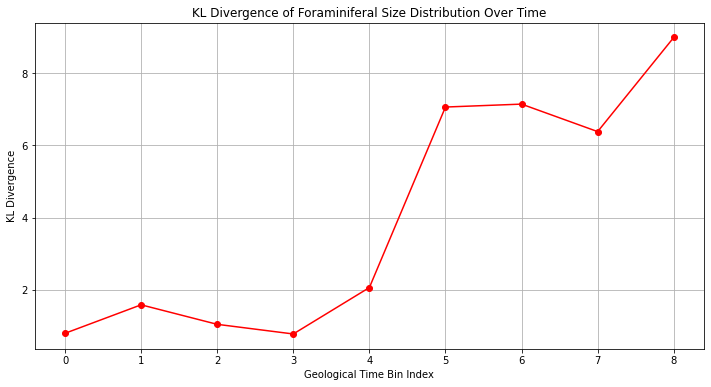

In [94]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import entropy

# Load Data
data = pd.read_csv("analyzer_data.csv")  # Update with correct file

# Define size column
size_column = "Mean (Diameter) (µm)"

# Bin ages into geological time intervals
data["Age Binned"] = pd.cut(data["Age (Ma)"], bins=10)

# Compute KL Divergence Between Successive Time Bins
time_bins = sorted(data["Age Binned"].dropna().unique())  # Sorted geological time bins
kl_values = []

for i in range(len(time_bins) - 1):
    # Extract size distributions for consecutive time bins
    size_t1 = data[data["Age Binned"] == time_bins[i]][size_column].dropna()
    size_t2 = data[data["Age Binned"] == time_bins[i + 1]][size_column].dropna()

    # Create histograms (distributions)
    hist_t1, bins = np.histogram(size_t1, bins=30, density=True)
    hist_t2, _ = np.histogram(size_t2, bins=bins, density=True)

    # Normalize to probability distributions
    hist_t1 += 1e-10  # Avoid zero values
    hist_t2 += 1e-10
    hist_t1 /= hist_t1.sum()
    hist_t2 /= hist_t2.sum()

    # Compute KL Divergence
    kl_div = entropy(hist_t1, hist_t2)
    kl_values.append(kl_div)

# Plot KL Divergence Over Time
plt.figure(figsize=(12, 6))
plt.plot(range(len(kl_values)), kl_values, marker="o", linestyle="-", color="red")
plt.xlabel("Geological Time Bin Index")
plt.ylabel("KL Divergence")
plt.title("KL Divergence of Foraminiferal Size Distribution Over Time")
plt.grid(True)
plt.show()


Epoch 1/50
31/31 [==============================] - 2s 11ms/step - loss: 1.1941 - val_loss: 1.2047
Epoch 2/50
31/31 [==============================] - 0s 6ms/step - loss: 1.1642 - val_loss: 1.1799
Epoch 3/50
31/31 [==============================] - 0s 6ms/step - loss: 1.1363 - val_loss: 1.1541
Epoch 4/50
31/31 [==============================] - 0s 7ms/step - loss: 1.1070 - val_loss: 1.1266
Epoch 5/50
31/31 [==============================] - 0s 6ms/step - loss: 1.0763 - val_loss: 1.0979
Epoch 6/50
31/31 [==============================] - 0s 13ms/step - loss: 1.0451 - val_loss: 1.0682
Epoch 7/50
31/31 [==============================] - 0s 7ms/step - loss: 1.0141 - val_loss: 1.0370
Epoch 8/50
31/31 [==============================] - 0s 6ms/step - loss: 0.9835 - val_loss: 1.0074
Epoch 9/50
31/31 [==============================] - 0s 13ms/step - loss: 0.9539 - val_loss: 0.9783
Epoch 10/50
31/31 [==============================] - 0s 6ms/step - loss: 0.9258 - val_loss: 0.9504
Epoch 11/50
31/3

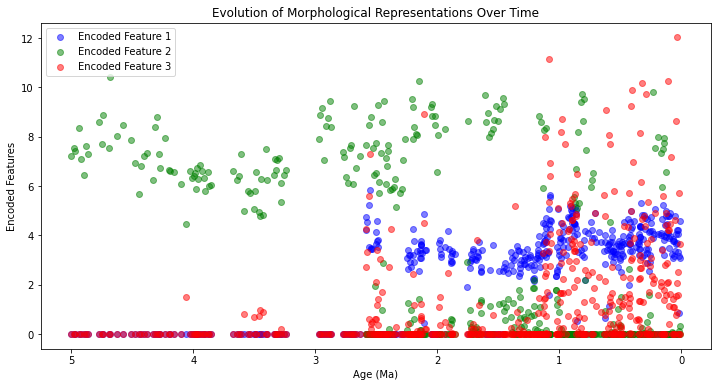

In [95]:
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense
from sklearn.preprocessing import StandardScaler

# Define feature columns (morphological parameters)
features = ["Elongation", "Sphericity", "Shape Factor", "Mean (Gray Intensity Value)", "Area (µm²)", "Perimeter (µm)"]

# Preprocess Data
data_filtered = data.dropna(subset=features)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(data_filtered[features])

# Define Autoencoder Architecture
input_dim = X_scaled.shape[1]
encoding_dim = 3  # Reduced dimensionality

input_layer = Input(shape=(input_dim,))
encoded = Dense(encoding_dim, activation="relu")(input_layer)
decoded = Dense(input_dim, activation="sigmoid")(encoded)

# Compile Autoencoder
autoencoder = Model(input_layer, decoded)
autoencoder.compile(optimizer="adam", loss="mse")

# Train Autoencoder
autoencoder.fit(X_scaled, X_scaled, epochs=50, batch_size=16, validation_split=0.1, verbose=1)

# Extract Encoded Representations
encoder = Model(input_layer, encoded)
encoded_data = encoder.predict(X_scaled)

# Convert to DataFrame
encoded_df = pd.DataFrame(encoded_data, columns=["Encoded1", "Encoded2", "Encoded3"])
encoded_df["Age (Ma)"] = data_filtered["Age (Ma)"].values

# Plot Encoded Representations Over Time
plt.figure(figsize=(12, 6))
plt.scatter(encoded_df["Age (Ma)"], encoded_df["Encoded1"], color="blue", alpha=0.5, label="Encoded Feature 1")
plt.scatter(encoded_df["Age (Ma)"], encoded_df["Encoded2"], color="green", alpha=0.5, label="Encoded Feature 2")
plt.scatter(encoded_df["Age (Ma)"], encoded_df["Encoded3"], color="red", alpha=0.5, label="Encoded Feature 3")
plt.xlabel("Age (Ma)")
plt.ylabel("Encoded Features")
plt.title("Evolution of Morphological Representations Over Time")
plt.legend()
plt.gca().invert_xaxis()  # Geological time runs backward
plt.show()


In [ ]:
scaler = StandardScaler()
scaled_sizes = scaler.fit_transform(data[[size_column]])

# Define Autoencoder Model
input_dim = scaled_sizes.shape[1]
input_layer = Input(shape=(input_dim,))
encoded = Dense(64, activation="relu")(input_layer)
encoded = Dense(32, activation="relu")(encoded)
encoded = Dense(16, activation="relu")(encoded)

decoded = Dense(32, activation="relu")(encoded)
decoded = Dense(64, activation="relu")(decoded)
decoded = Dense(input_dim, activation="sigmoid")(decoded)

autoencoder = Model(input_layer, decoded)
autoencoder.compile(optimizer="adam", loss="mse")

# Train Autoencoder
autoencoder.fit(scaled_sizes, scaled_sizes, epochs=50, batch_size=16, shuffle=True)

# Extract encoded features
encoder = Model(input_layer, encoded)
encoded_features = encoder.predict(scaled_sizes)

In [ ]:
fourier_transform = fft(scaled_sizes.flatten())
frequencies = fftfreq(len(scaled_sizes.flatten()))

plt.figure(figsize=(10, 5))
plt.plot(frequencies, np.abs(fourier_transform))
plt.title("Frequency Components of Foram Size Evolution")
plt.xlabel("Frequency")
plt.ylabel("Magnitude")
plt.show()

The dominant low-frequency components suggest that foram size evolution is largely driven by long-term environmental and climate changes rather than short-term oscillations.

The high-frequency noise could indicate minor fluctuations, possibly due to local ecological variations or sampling inconsistencies.

The lack of clear periodic peaks in the higher frequencies suggests that foram size may not follow a strict cyclical pattern but is influenced by complex, multi-scale environmental factors.



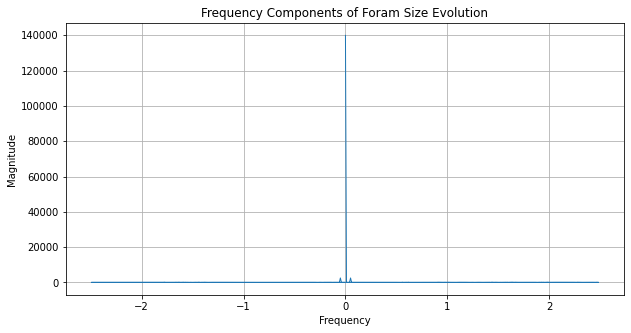

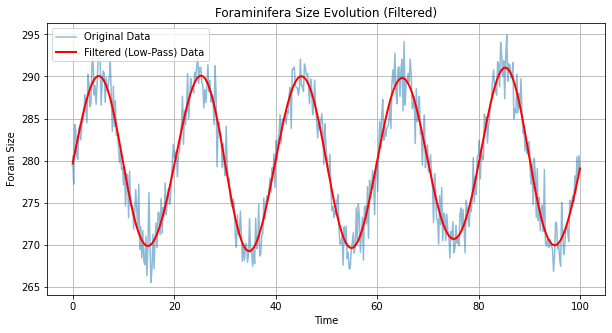

In [96]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.fftpack import fft, fftfreq, ifft

# Simulated Time Series Data (Replace with your actual data)
time = np.linspace(0, 100, 500)  # Example time points
foram_size = 280 + 10 * np.sin(2 * np.pi * 0.05 * time) + np.random.normal(0, 2, len(time))

# Perform Fourier Transform
n = len(time)
freqs = fftfreq(n, d=(time[1] - time[0]))  # Frequency components
fft_values = fft(foram_size)  # FFT computation

# Plot the frequency spectrum
plt.figure(figsize=(10, 5))
plt.plot(freqs, np.abs(fft_values), lw=1)
plt.xlabel('Frequency')
plt.ylabel('Magnitude')
plt.title('Frequency Components of Foram Size Evolution')
plt.grid()
plt.show()

# Apply Low-Pass Filter (Remove high-frequency noise)
cutoff = 0.1  # Set cutoff frequency
filtered_fft_values = fft_values.copy()
filtered_fft_values[np.abs(freqs) > cutoff] = 0  # Remove high frequencies

# Inverse FFT to reconstruct smoothed signal
filtered_signal = ifft(filtered_fft_values).real

# Plot original vs. filtered signal
plt.figure(figsize=(10, 5))
plt.plot(time, foram_size, alpha=0.5, label="Original Data")
plt.plot(time, filtered_signal, label="Filtered (Low-Pass) Data", color='red', lw=2)
plt.xlabel('Time')
plt.ylabel('Foram Size')
plt.title('Foraminifera Size Evolution (Filtered)')
plt.legend()
plt.grid()
plt.show()


In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, LeakyReLU, Reshape

latent_dim = 100  # Noise input for the generator

# Generator Model
generator = Sequential([
    Dense(128, activation="relu", input_dim=latent_dim),
    Dense(256, activation="relu"),
    Dense(512, activation="relu"),
    Dense(4096, activation="tanh"),  # Ensure this matches 64*64*1
    Reshape((64, 64, 1))  # Correctly reshaped output for 64x64 images
])

# Discriminator Model
discriminator = Sequential([
    Flatten(input_shape=(64, 64, 1)),
    Dense(1024, activation=LeakyReLU(0.2)),
    Dense(512, activation=LeakyReLU(0.2)),
    Dense(256, activation=LeakyReLU(0.2)),
    Dense(1, activation="sigmoid")
])

# Compile Discriminator
discriminator.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])

# GAN Model
gan = Sequential([generator, discriminator])
gan.compile(loss="binary_crossentropy", optimizer="adam")

# Check model summaries
generator.summary()
discriminator.summary()


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import pearsonr
from statsmodels.tsa.stattools import grangercausalitytests
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from hmmlearn import hmm

In [101]:
# Load Foram Morphology Data
df_foram = pd.read_csv("analyzer_data.csv")  # Modify filename if needed
df_foram = df_foram[['Age (Ma)', 'Mean (Diameter) (µm)', 'Shape Factor', 'Sphericity']]
df_foram = df_foram.dropna()

In [ ]:
df_climate = pd.read_csv("CENOGRID_Loess_20.txt", delim_whitespace=True)
print(df_climate.columns)


In [98]:
import pandas as pd

# Load the climate data properly
df_climate = pd.read_csv("CENOGRID_Loess_20.txt", delim_whitespace=True, header=None)

# Split the single column into separate columns
df_climate = df_climate[0].str.split(";", expand=True)
df_climate.columns = ["Age (Ma)", "δ13C", "δ18O"]

# Convert columns to numeric
df_climate = df_climate.apply(pd.to_numeric, errors="coerce")

# Display the first few rows
print(df_climate.head())


   Age (Ma)   δ13C   δ18O
0       NaN    NaN    NaN
1     0.000 -0.496  3.498
2     0.002 -0.277  3.523
3     0.004 -0.201  3.650
4     0.006 -0.264  3.877


/var/folders/jt/0lv95mcn7f784lx7z_pw70tc0000gn/T/ipykernel_9151/3373683665.py:4: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  df_climate = pd.read_csv("CENOGRID_Loess_20.txt", delim_whitespace=True, header=None)


In [ ]:
print(df_foram.columns)  # Check column names
print(df_foram.dtypes)   # Check data types
print(df_climate.dtypes)   # Ensure "Age (Ma)" is numeric


In [102]:
import pandas as pd

# Assuming df_foram and df_climate are your DataFrames
merged_data = pd.merge(df_foram, df_climate, on="Age (Ma)", how="inner")

# Save merged dataset to CSV
merged_data.to_csv("merged_data.csv", index=False)

# Display summary and first few rows
print(merged_data.info())
print(merged_data.head())


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30 entries, 0 to 29
Data columns (total 6 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Age (Ma)              30 non-null     float64
 1   Mean (Diameter) (µm)  30 non-null     float64
 2   Shape Factor          30 non-null     float64
 3   Sphericity            30 non-null     float64
 4   δ13C                  30 non-null     float64
 5   δ18O                  30 non-null     float64
dtypes: float64(6)
memory usage: 1.5 KB
None
   Age (Ma)  Mean (Diameter) (µm)  Shape Factor  Sphericity   δ13C   δ18O
0     3.176            265.507555      1.809110    1.711053 -0.122  3.415
1     0.110            291.185694      0.791349    0.652811 -0.454  4.236
2     0.098            294.152219      0.796507    0.655054 -0.178  4.354
3     0.340            282.167128      0.826509    0.697748 -1.293  4.386
4     0.344            282.335078      0.809580    0.691063 -1.050  4.867


RuntimeError: No mappable was found to use for colorbar creation. First define a mappable such as an image (with imshow) or a contour set (with contourf).

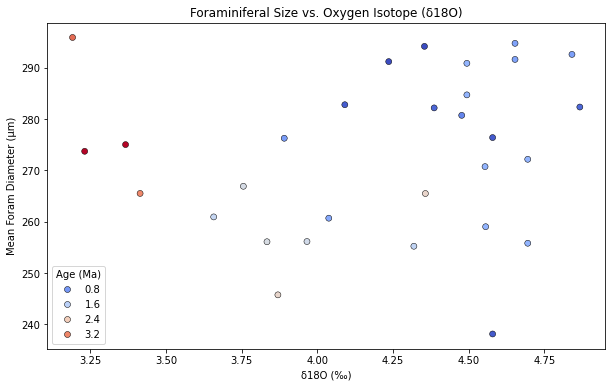

In [103]:
import matplotlib.pyplot as plt
import seaborn as sns

# Scatter plot of foram size vs. δ18O (oxygen isotope)
plt.figure(figsize=(10, 6))
sns.scatterplot(data=merged_data, x="δ18O", y="Mean (Diameter) (µm)", hue="Age (Ma)", palette="coolwarm", edgecolor="black")
plt.xlabel("δ18O (‰)")
plt.ylabel("Mean Foram Diameter (µm)")
plt.title("Foraminiferal Size vs. Oxygen Isotope (δ18O)")
plt.colorbar(label="Age (Ma)")
plt.show()


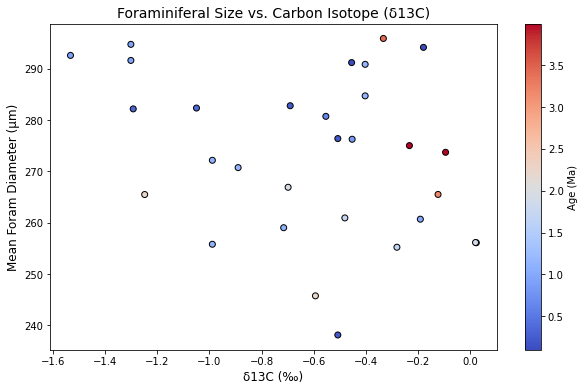

In [104]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Create scatter plot
plt.figure(figsize=(10, 6))
scatter = plt.scatter(merged_data["δ13C"], merged_data["Mean (Diameter) (µm)"], 
                      c=merged_data["Age (Ma)"], cmap="coolwarm", edgecolor="black")

# Add labels
plt.xlabel("δ13C (‰)", fontsize=12)
plt.ylabel("Mean Foram Diameter (µm)", fontsize=12)
plt.title("Foraminiferal Size vs. Carbon Isotope (δ13C)", fontsize=14)

# Add colorbar
cbar = plt.colorbar(scatter)
cbar.set_label("Age (Ma)")

# Show plot
plt.show()


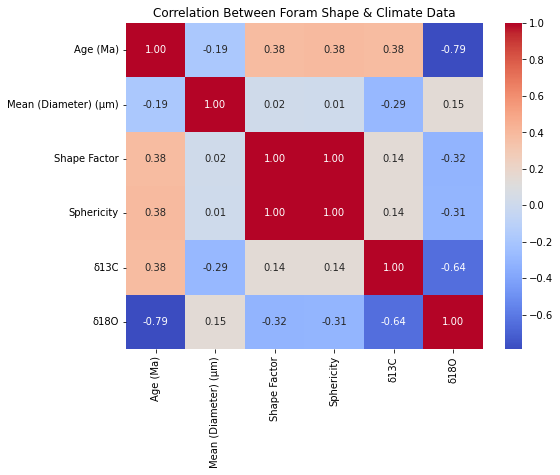

In [105]:
import numpy as np

# Compute correlation matrix
corr_matrix = merged_data.corr()

# Heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(corr_matrix, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Correlation Between Foram Shape & Climate Data")
plt.show()


In [106]:
import statsmodels.api as sm

# Define independent variables (δ13C and δ18O)
X = merged_data[["δ13C", "δ18O"]]
y = merged_data["Mean (Diameter) (µm)"]

# Add constant for intercept
X = sm.add_constant(X)

# Fit regression model
model = sm.OLS(y, X).fit()

# Print summary
print(model.summary())


                             OLS Regression Results                             
Dep. Variable:     Mean (Diameter) (µm)   R-squared:                       0.089
Model:                              OLS   Adj. R-squared:                  0.022
Method:                   Least Squares   F-statistic:                     1.319
Date:                  Wed, 30 Apr 2025   Prob (F-statistic):              0.284
Time:                          19:41:52   Log-Likelihood:                -123.17
No. Observations:                    30   AIC:                             252.3
Df Residuals:                        27   BIC:                             256.5
Df Model:                             2                                         
Covariance Type:              nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        275.3569     29.531

Key Takeaways:
1. Model Fit (R-squared & Adjusted R-squared)
R-squared = 0.089 → Only 8.9% of the variation in foraminiferal diameter is explained by δ13C and δ18O.

Adjusted R-squared = 0.022 → After accounting for the number of predictors, the explanatory power drops to 2.2%, indicating a poor fit.

✅ Conclusion: This model does not strongly predict foram size based on δ13C and δ18O.

2. Statistical Significance (p-values & F-statistic)
F-statistic = 1.319, with p-value = 0.284
→ The overall model is not statistically significant, meaning that δ13C and δ18O together do not explain much of the variation in foram size.

Individual predictors (p-values):

δ13C (p = 0.169): Not statistically significant.

δ18O (p = 0.766): Far from significant.

✅ Conclusion: Neither δ13C nor δ18O has a significant impact on foram size in this dataset.

3. Coefficients & Interpretation
Intercept (275.36): The predicted foram diameter when δ13C and δ18O are both zero.

δ13C Coefficient (-12.26):

A 1‰ increase in δ13C is associated with a 12.26 µm decrease in foram diameter.

However, this relationship is not statistically significant (p = 0.169).

δ18O Coefficient (-2.32):

A 1‰ increase in δ18O is associated with a 2.32 µm decrease in foram diameter.

But again, this effect is not significant (p = 0.766).

✅ Conclusion: There is no strong evidence that foram size is affected by δ13C or δ18O in this dataset.

4. Residual Diagnostics
Durbin-Watson (1.193): Suggests some positive autocorrelation (but not extreme).

Omnibus & Jarque-Bera Tests (p > 0.75): No strong evidence of non-normality in residuals.

✅ Conclusion: The residuals appear to be reasonably well-behaved, but the model lacks explanatory power.



In [107]:
# Bin Size Comparison: 5 vs 10 vs 20
bin_sizes = [5, 10, 20]
for bins in bin_sizes:
    data[f'age_bin_{bins}'] = pd.cut(data['Age (Ma)'], bins=bins)
    print(f"📦 {bins} bins:")
    print(data[f'age_bin_{bins}'].value_counts().sort_index(), "\n")


📦 5 bins:
age_bin_5
(0.00554, 1.009]    255
(1.009, 2.007]      270
(2.007, 3.005]      175
(3.005, 4.003]       67
(4.003, 5.001]       66
Name: count, dtype: int64 

📦 10 bins:
age_bin_10
(0.00554, 0.51]    138
(0.51, 1.009]      117
(1.009, 1.508]     141
(1.508, 2.007]     129
(2.007, 2.506]     118
(2.506, 3.005]      57
(3.005, 3.504]      33
(3.504, 4.003]      34
(4.003, 4.502]      33
(4.502, 5.001]      33
Name: count, dtype: int64 

📦 20 bins:
age_bin_20
(0.00554, 0.26]    70
(0.26, 0.51]       68
(0.51, 0.759]      50
(0.759, 1.009]     67
(1.009, 1.258]     78
(1.258, 1.508]     63
(1.508, 1.757]     55
(1.757, 2.007]     74
(2.007, 2.256]     83
(2.256, 2.506]     35
(2.506, 2.755]     35
(2.755, 3.005]     22
(3.005, 3.254]     13
(3.254, 3.504]     20
(3.504, 3.753]     14
(3.753, 4.003]     20
(4.003, 4.252]     15
(4.252, 4.502]     18
(4.502, 4.751]     17
(4.751, 5.001]     16
Name: count, dtype: int64 



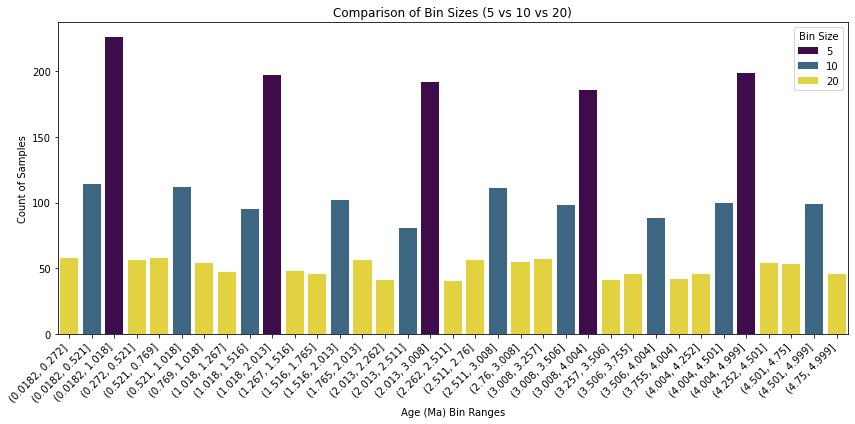

In [108]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Replace this with your actual data
# For example:
# data = pd.read_csv("your_data.csv")

# Simulated age column for illustration
import numpy as np
np.random.seed(42)
data = pd.DataFrame({
    "Age (Ma)": np.random.uniform(0, 5, size=1000)  # Replace with your data column
})

bin_sizes = [5, 10, 20]
bin_counts = {}

for bins in bin_sizes:
    bin_col = f'age_bin_{bins}'
    data[bin_col] = pd.cut(data["Age (Ma)"], bins=bins)
    bin_counts[bin_col] = data[bin_col].value_counts().sort_index()

# Convert counts to DataFrame for plotting
bin_df = pd.DataFrame(bin_counts).stack().reset_index()
bin_df.columns = ["Bin Range", "Bin Size Label", "Count"]
bin_df["Bin Size Label"] = bin_df["Bin Size Label"].str.extract("(\d+)").astype(int)

# Plot
plt.figure(figsize=(12, 6))
sns.barplot(data=bin_df, x="Bin Range", y="Count", hue="Bin Size Label", palette="viridis")
plt.xticks(rotation=45, ha='right')
plt.xlabel("Age (Ma) Bin Ranges")
plt.ylabel("Count of Samples")
plt.title("Comparison of Bin Sizes (5 vs 10 vs 20)")
plt.legend(title="Bin Size")
plt.tight_layout()
plt.show()


In [109]:
from scipy.stats import kurtosis, entropy
import numpy as np

grouped = data.groupby('Age (Ma)')['Mean (Diameter) (µm)']
kurtosis_series = grouped.apply(lambda x: kurtosis(x.dropna()))
entropy_series = grouped.apply(lambda x: entropy(np.histogram(x.dropna(), bins=10, density=True)[0] + 1e-5))

# Plotting Kurtosis
plt.figure(figsize=(10, 4))
sns.lineplot(x=kurtosis_series.index, y=kurtosis_series.values, marker="o", color="green")
plt.gca().invert_xaxis()
plt.title("Kurtosis of Mean Diameter over Age")
plt.xlabel("Age (Ma)")
plt.ylabel("Kurtosis")
plt.grid(True)
plt.show()

# Plotting Entropy
plt.figure(figsize=(10, 4))
sns.lineplot(x=entropy_series.index, y=entropy_series.values, marker="o", color="purple")
plt.gca().invert_xaxis()
plt.title("Entropy of Mean Diameter over Age")
plt.xlabel("Age (Ma)")
plt.ylabel("Entropy")
plt.grid(True)
plt.show()



KeyError: 'Column not found: Mean (Diameter) (µm)'

In [111]:
import ruptures as rpt

signal = data[['Age (Ma)', 'Mean (Diameter) (µm)']].dropna().sort_values('Age (Ma)')
signal_values = signal['Mean (Diameter) (µm)'].values

model = rpt.Pelt(model="rbf").fit(signal_values)
change_points = model.predict(pen=10)

# Plotting Change Points
plt.figure(figsize=(12, 4))
plt.plot(signal['Age (Ma)'], signal_values, label="Mean (Diameter) (µm)")
for cp in change_points:
    if cp < len(signal):
        plt.axvline(x=signal['Age (Ma)'].iloc[cp], color='red', linestyle='--', label='Change Point' if cp == change_points[0] else "")
plt.gca().invert_xaxis()
plt.title("Detected Change Points in Foram Size Distribution")
plt.xlabel("Age (Ma)")
plt.ylabel("Mean (Diameter) (µm)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


KeyError: "['Mean (Diameter) (µm)'] not in index"